# Demo of the GTM on 10-Dimensional R-Vine-Copula Data

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 10 dimensional R-Vine-Copula as done in our [Paper](https://arxiv.org/pdf/2503.17845) Section 4.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [40]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv
# Helpers to generate specfific vines and analyze there conditional independencies
from pyvinecopulib_simulation_helpers import *

# Other Stuff
import numpy as np
import torch
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
from sklearn.metrics import roc_auc_score, roc_curve

In [41]:
set_seeds(1)

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a R-Vine-Copula and add Gaussian marginals. To create the Vine we use the functions `sample_random_pair_copulas`and `compute_conditional_dependence_table` from our helpers. Theses allow use to set independence copulas upon Tree 3 to add full conditional independencies as detailed in our Paper. The `df`contains a tables with the copulas, there parameters and there tree positions in a manner comparable to the conditional independence table later generated with the GTM.

In [42]:
D = 8  # dimension
rvine_structure = pv.RVineStructure.simulate(D)
pair_copulas = sample_random_pair_copulas(D,Independence_tree=3)
vine_model = pv.Vinecop.from_structure(structure=rvine_structure, pair_copulas=pair_copulas)
df = compute_conditional_dependence_table(vine_model)
#df

creating a table to compare the true dependence structure later on to what the gtm learned

In [43]:

df_true_structure = df[["tree","edge","conditioned variables", "conditioned variable 1", "conditioned variable 2", "dependence", "var_row", "var_col"]]
df_true_structure_sub = df_true_structure[["var_row", "var_col", "dependence"]]
df_true_structure_sub.loc[:, "var_row"] = df_true_structure_sub["var_row"] - 1
df_true_structure_sub.loc[:, "var_col"] = df_true_structure_sub["var_col"] - 1

The `pyvinecopulib`package offers to plot the tree structures:

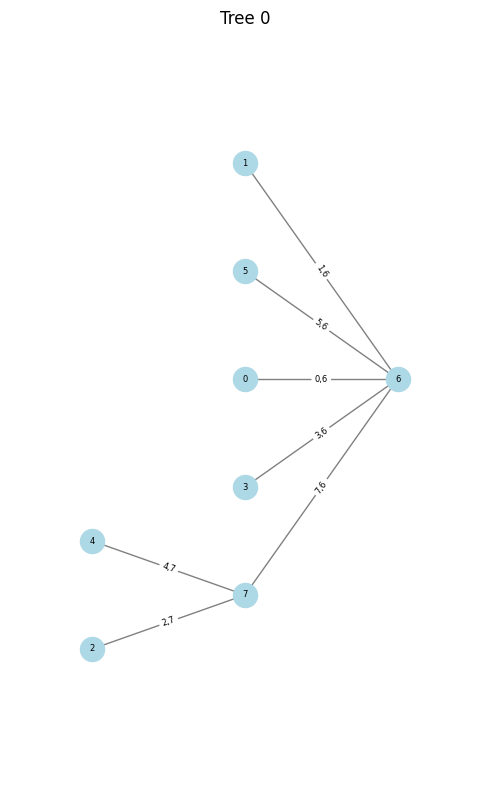

In [44]:
vine_model.plot(tree=[0])

In [45]:
# Train
N_train = 2000
simulated_data_uniform_train = vine_model.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = vine_model.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = vine_model.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [46]:
loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_train).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_validate).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_test).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [47]:
copula_pv_est = vine_model
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [48]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [49]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [50]:
model_freq = GTM(
        number_variables = D,
        number_transformation_layers = 1,
        number_decorrelation_layers= 3,
        degree_transformations = 15,
        degree_decorrelation = 30,
        spline_transformation = "bspline",
        spline_decorrelation = "bspline",
        transformation_spline_range = (-10, 10),
        device = "cuda" if torch.cuda.is_available() else "cpu")

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [51]:
#model_freq.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [52]:
#model_freq.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

#### 3.1 GTM

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [53]:
study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-11 16:26:39,802] A new study created in RDB with name: no-name-607cac5e-45ee-4a71-a6d1-11f496188937
  0%|          | 4/2000 [00:00<01:08, 29.18it/s]

current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4300721883773804
current_loss: tensor(1.4262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.425422191619873
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4165937900543213
current_loss: tensor(1.4095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.415228247642517
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>

  0%|          | 10/2000 [00:00<01:11, 27.74it/s]

current_loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4149800539016724
current_loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4149600267410278
current_loss: tensor(1.4076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4152112007141113
current_loss: tensor(1.4073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4155906438827515
current_loss: tensor(1.4073, device='cuda:0', grad_fn=<MeanBackward

  1%|          | 12/2000 [00:00<01:16, 26.12it/s]


current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4159023761749268
Early Stop at iteration 12 with minimal loss tensor(1.4150, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<03:27,  9.63it/s]

current_loss: tensor(1.4104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3272658586502075
current_loss: tensor(1.3218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1851465702056885


  0%|          | 3/2000 [00:00<03:25,  9.73it/s]

current_loss: tensor(1.1863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.6201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1639310121536255
current_loss: tensor(1.1662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1473257541656494
current_loss: tensor(1.1499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2071, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:46, 11.95it/s]

current_loss: tensor(1.1173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1115049123764038
current_loss: tensor(1.1173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0848348140716553
current_loss: tensor(1.0967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0736984014511108
current_loss: tensor(1.0869, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:50, 11.66it/s]

current_loss: tensor(1.0824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0692644119262695
current_loss: tensor(1.0824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.060911774635315
current_loss: tensor(1.0742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0607, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:44, 12.10it/s]

current_loss_val:  1.04237699508667
current_loss: tensor(1.0607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0330497026443481
current_loss: tensor(1.0517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0283246040344238
current_loss: tensor(1.0470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0305, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:29, 13.28it/s]

current_loss_val:  1.0119036436080933
current_loss: tensor(1.0305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0121395587921143
current_loss: tensor(1.0288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0064560174942017
current_loss: tensor(1.0234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0214, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:26, 13.55it/s]

current_loss_val:  1.0047249794006348
current_loss: tensor(1.0214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0026124715805054
current_loss: tensor(1.0182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0042974948883057
current_loss: tensor(1.0167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0129, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:20, 14.08it/s]

current_loss_val:  1.0007593631744385
current_loss: tensor(1.0129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9986485242843628
current_loss: tensor(1.0102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9970837831497192
current_loss: tensor(1.0075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9988, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:19, 14.15it/s]

current_loss_val:  0.9925787448883057
current_loss: tensor(0.9988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9960597157478333
current_loss: tensor(0.9980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9908339977264404
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:18, 14.29it/s]

current_loss_val:  0.9894128441810608
current_loss: tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9885515570640564
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9876624941825867
current_loss: tensor(0.9896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9869, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:17, 14.31it/s]

current_loss_val:  0.9852667450904846
current_loss: tensor(0.9869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9840990304946899
current_loss: tensor(0.9862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.983289361000061
current_loss: tensor(0.9852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:19, 14.13it/s]

current_loss_val:  0.9828644394874573
current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9824665784835815
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9823979735374451
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:19, 14.13it/s]

current_loss_val:  0.98197340965271
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9812360405921936
current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9810701012611389
current_loss: tensor(0.9817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:02<02:17, 14.28it/s]

current_loss_val:  0.9791052937507629
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9784082770347595
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9776507019996643
current_loss: tensor(0.9784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9784, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:24, 13.51it/s]

current_loss: tensor(0.9774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9765685200691223
current_loss: tensor(0.9774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9758431315422058
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9753807783126831
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:20, 13.96it/s]

current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9742761850357056
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9728938341140747
current_loss: tensor(0.9752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9724178910255432
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:03<02:18, 14.08it/s]

current_loss: tensor(0.9710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9696438908576965
current_loss: tensor(0.9710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9668557643890381
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9654690623283386
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:03<02:17, 14.14it/s]

current_loss: tensor(0.9627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9636529684066772
current_loss: tensor(0.9627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585586786270142
current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:03<02:23, 13.58it/s]

current_loss_val:  0.957129716873169


  3%|▎         | 53/2000 [00:03<02:21, 13.79it/s]

current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.956357479095459
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955169141292572
current_loss: tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537906050682068


  3%|▎         | 55/2000 [00:04<02:26, 13.27it/s]

current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535372257232666
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9532783031463623
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:04<02:25, 13.37it/s]

current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9533703923225403
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.953498899936676
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535089135169983
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:04<02:22, 13.59it/s]

current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9533244967460632
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9528407454490662
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516007304191589
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:04<02:18, 13.99it/s]

current_loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9513193964958191
current_loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9503657817840576
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9491761922836304
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:04<02:17, 14.10it/s]

current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9485016465187073
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477340579032898
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476562738418579
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:05<02:14, 14.33it/s]

current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477475881576538
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478573799133301
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9479877352714539
current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:05<02:23, 13.41it/s]


current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478265643119812
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947713315486908
Early Stop at iteration 72 with minimal loss tensor(0.9477, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 16:26:46,327] Trial 0 finished with value: -7.581250190734863 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.267494740120448, 'penalty_decorrelation_ridge_second_difference': 21.581424631027616}. Best is trial 0 with value: -7.581250190734863.
  0%|          | 2/2000 [00:00<02:26, 13.63it/s]

current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9479473233222961
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476521611213684
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947550356388092


  0%|          | 4/2000 [00:00<02:23, 13.87it/s]

current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475243091583252
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475772976875305
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:26, 13.57it/s]

current_loss_val:  0.9475111365318298
current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9473931193351746
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9466084837913513
current_loss: tensor(0.9340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:32, 13.05it/s]

current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.945625364780426
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9449949264526367
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9441890120506287
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:31, 13.12it/s]

current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9426369071006775
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9421703219413757
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9418137073516846


  1%|          | 16/2000 [00:01<02:32, 12.97it/s]

current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9412437081336975
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409463405609131
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:37, 12.57it/s]

current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9402858018875122
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400700926780701
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398524761199951
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:28, 13.31it/s]

current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397726655006409
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9394206404685974
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393484592437744
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:26, 13.46it/s]

current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392804503440857
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392471313476562
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391593933105469
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:22, 13.81it/s]

current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391338229179382
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390799403190613
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392012357711792
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:21, 13.91it/s]

current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9388951659202576
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938798725605011
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386606216430664
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:19, 14.13it/s]

current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938635528087616
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386210441589355
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938595712184906
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:25, 13.46it/s]

current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384593963623047
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381691813468933
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380365610122681


  2%|▏         | 40/2000 [00:02<02:23, 13.68it/s]

current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376055002212524
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936368465423584
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355651140213013


  2%|▏         | 42/2000 [00:03<02:28, 13.22it/s]

current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346100091934204
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340260028839111
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:25, 13.48it/s]

current_loss_val:  0.9332506656646729
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9308777451515198
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303848743438721
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:19, 14.03it/s]

current_loss_val:  0.9296637177467346
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929521381855011
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295737743377686
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:18, 14.10it/s]

current_loss_val:  0.9293498992919922
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291611909866333
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288923144340515
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:03<02:15, 14.34it/s]

current_loss_val:  0.9286057949066162
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9284249544143677
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9281182289123535
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:15, 14.36it/s]

current_loss_val:  0.9282116889953613
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9279378652572632
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.927860677242279
current_loss: tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:19, 13.93it/s]

current_loss_val:  0.927695095539093
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9274560809135437
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9273867607116699
current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:24, 13.41it/s]

current_loss_val:  0.9272535443305969
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9269720911979675
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9269129633903503
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:04<02:33, 12.62it/s]

current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9267333149909973
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9263169169425964
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9261289238929749


  3%|▎         | 68/2000 [00:05<02:44, 11.71it/s]

current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9259957671165466
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9258701801300049


  4%|▎         | 70/2000 [00:05<02:54, 11.03it/s]

current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9256184697151184
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9256102442741394
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:05<02:43, 11.80it/s]

current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9254819750785828
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9253789782524109
current_loss: tensor(0.9043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9252999424934387
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:05<02:28, 12.97it/s]

current_loss: tensor(0.9041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9251905679702759
current_loss: tensor(0.9041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9250853657722473
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9250428676605225
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 78/2000 [00:05<02:24, 13.29it/s]

current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9249658584594727
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9248657822608948
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9248518347740173
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 82/2000 [00:06<02:25, 13.18it/s]

current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9248437881469727
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9248296618461609
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9247987866401672


  4%|▍         | 84/2000 [00:06<02:24, 13.22it/s]

current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9248009324073792
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9247814416885376
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 86/2000 [00:06<02:37, 12.15it/s]

current_loss_val:  0.9248906373977661
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.924716591835022
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9246643781661987
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 90/2000 [00:06<02:35, 12.26it/s]

current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9245554804801941
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9245643615722656
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9245461821556091


  5%|▍         | 92/2000 [00:07<02:44, 11.58it/s]

current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9244188070297241
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9244033694267273
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 94/2000 [00:07<02:42, 11.70it/s]

current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9243768453598022
current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9243636131286621
current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9243578314781189


  5%|▍         | 96/2000 [00:07<02:33, 12.37it/s]

current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.924353301525116
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.924410343170166
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 100/2000 [00:07<02:26, 12.93it/s]

current_loss_val:  0.9244278073310852
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.924400806427002
current_loss: tensor(0.9022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9244966506958008
current_loss: tensor(0.9017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 100/2000 [00:07<02:26, 12.98it/s]


current_loss_val:  0.9245791435241699
Early Stop at iteration 100 with minimal loss tensor(0.9244, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 16:26:54,620] Trial 1 finished with value: -7.3948259353637695 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.777910416219957, 'penalty_decorrelation_ridge_second_difference': 28.93237590916425}. Best is trial 1 with value: -7.3948259353637695.
  0%|          | 2/2000 [00:00<02:24, 13.81it/s]

current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478801488876343
current_loss: tensor(0.9325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475641250610352
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474238753318787


  0%|          | 6/2000 [00:00<02:20, 14.24it/s]

current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9473516941070557
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475314021110535
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9471167325973511


  0%|          | 8/2000 [00:00<02:19, 14.33it/s]

current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9469586610794067
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9464277625083923
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9456291794776917


  1%|          | 12/2000 [00:00<02:18, 14.39it/s]

current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9446474313735962
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9441878795623779
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9440038204193115


  1%|          | 14/2000 [00:00<02:18, 14.34it/s]

current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9437170028686523
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9434451460838318
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9428800344467163


  1%|          | 18/2000 [00:01<02:18, 14.35it/s]

current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9422776699066162
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9418721199035645
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9408414959907532


  1%|          | 20/2000 [00:01<02:17, 14.39it/s]

current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9388065338134766
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377865195274353
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9374051690101624


  1%|          | 24/2000 [00:01<02:17, 14.39it/s]

current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351349472999573
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9341912269592285
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9341350793838501


  1%|▏         | 26/2000 [00:01<02:16, 14.42it/s]

current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9342318773269653
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346712231636047
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353893399238586


  1%|▏         | 28/2000 [00:02<02:22, 13.85it/s]

current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354019165039062
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353002309799194
Early Stop at iteration 28 with minimal loss tensor(0.9341, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 16:26:57,248] Trial 2 finished with value: -7.473080158233643 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.192394670565781, 'penalty_decorrelation_ridge_second_difference': 19.896805117594216}. Best is trial 1 with value: -7.3948259353637695.
  0%|          | 2/2000 [00:00<02:23, 13.89it/s]

current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9479354619979858
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476321339607239
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475311636924744


  0%|          | 6/2000 [00:00<02:19, 14.27it/s]

current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947494626045227
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947637140750885
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475039839744568


  0%|          | 8/2000 [00:00<02:28, 13.45it/s]

current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474132657051086
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9469650983810425
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:36, 12.73it/s]

current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9458112120628357
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.944464921951294
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9442728757858276
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:25, 13.63it/s]

current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9442333579063416
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9442621469497681
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9442898631095886
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:36, 12.64it/s]

current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9442622661590576
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9442836046218872
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9442546963691711
Early Stop at iteration 16 with minimal loss tensor(0.9442, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 16:26:59,089] Trial 3 finished with value: -7.553867340087891 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.656398171623055, 'penalty_decorrelation_ridge_second_difference': 13.588422803825043}. Best is trial 1 with value: -7.3948259353637695.
  0%|          | 2/2000 [00:00<02:21, 14.08it/s]

current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478005766868591
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474744200706482
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472357630729675


  0%|          | 4/2000 [00:00<02:20, 14.21it/s]

current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9471060037612915
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9469617605209351
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:36, 12.76it/s]

current_loss_val:  0.9467335939407349
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9446410536766052
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9440831542015076
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:29, 13.29it/s]

current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9437493681907654
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9416957497596741
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940547525882721
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:24, 13.76it/s]

current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9403562545776367
current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940308153629303
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9404541254043579
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:22, 13.96it/s]

current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409610033035278
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409893751144409
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940719485282898


  1%|          | 17/2000 [00:01<02:35, 12.73it/s]


current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940406322479248
Early Stop at iteration 17 with minimal loss tensor(0.9403, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 16:27:01,022] Trial 4 finished with value: -7.522465229034424 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.8221891700908304, 'penalty_decorrelation_ridge_second_difference': 12.327522125510916}. Best is trial 1 with value: -7.3948259353637695.
  0%|          | 2/2000 [00:00<02:21, 14.13it/s]

current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9480950236320496
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947930097579956
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.948091983795166


  0%|          | 6/2000 [00:00<02:18, 14.43it/s]

current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9484037756919861
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9491644501686096
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9486936926841736


  0%|          | 6/2000 [00:00<02:42, 12.26it/s]


current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9484745264053345
Early Stop at iteration 6 with minimal loss tensor(0.9479, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 16:27:02,107] Trial 5 finished with value: -7.583440780639648 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.020910764599137, 'penalty_decorrelation_ridge_second_difference': 25.981421687658276}. Best is trial 1 with value: -7.3948259353637695.
  0%|          | 2/2000 [00:00<02:18, 14.40it/s]

current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.948054850101471
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478310346603394
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478462338447571


  0%|          | 4/2000 [00:00<02:19, 14.36it/s]

current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9479712843894958
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9481449127197266
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:50, 11.69it/s]

current_loss_val:  0.9481700658798218
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9485509395599365
Early Stop at iteration 6 with minimal loss tensor(0.9478, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 16:27:03,210] Trial 6 finished with value: -7.582647323608398 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.691195236361217, 'penalty_decorrelation_ridge_second_difference': 26.950833501902185}. Best is trial 1 with value: -7.3948259353637695.
  0%|          | 2/2000 [00:00<02:19, 14.27it/s]

current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9480146169662476
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477506279945374
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:31, 13.18it/s]

current_loss_val:  0.9476937055587769
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477272033691406
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9486295580863953
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:45, 12.03it/s]

current_loss_val:  0.9481813907623291
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9480557441711426
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477470517158508
Early Stop at iteration 7 with minimal loss tensor(0.9477, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 16:27:04,404] Trial 7 finished with value: -7.581548690795898 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.9440676486831, 'penalty_decorrelation_ridge_second_difference': 14.634458172538015}. Best is trial 1 with value: -7.3948259353637695.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478340744972229
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<06:37,  5.03it/s]

current_loss_val:  0.9475233554840088
current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<07:55,  4.20it/s]

current_loss_val:  0.947333037853241
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<09:13,  3.61it/s]

current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472388029098511


  0%|          | 5/2000 [00:01<08:39,  3.84it/s]

current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947167158126831
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9469860196113586
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:58,  6.67it/s]

current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9462099075317383
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9453916549682617
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:51,  6.83it/s]

current_loss_val:  0.9445847272872925
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<07:32,  4.40it/s]

current_loss_val:  0.942764937877655
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<08:29,  3.90it/s]

current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9423890113830566
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.942153811454773
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:33,  7.26it/s]

current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9410628080368042
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9402446150779724
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397845268249512


  1%|          | 17/2000 [00:02<03:45,  8.81it/s]

current_loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390823245048523
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376603960990906
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9372459650039673


  1%|          | 21/2000 [00:03<02:58, 11.11it/s]

current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370935559272766
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936312198638916
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356049299240112


  1%|          | 23/2000 [00:03<02:47, 11.78it/s]

current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354302287101746
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352807402610779
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<02:40, 12.29it/s]

current_loss_val:  0.9352577924728394
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353132843971252
current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356174468994141
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<04:25,  7.42it/s]

current_loss_val:  0.9355842471122742
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355869293212891
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356550574302673
Early Stop at iteration 28 with minimal loss tensor(0.9353, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 16:27:08,779] Trial 8 finished with value: -7.482061862945557 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.666329493306655, 'penalty_decorrelation_ridge_second_difference': 3.6191599227456956}. Best is trial 1 with value: -7.3948259353637695.
  0%|          | 2/2000 [00:00<02:23, 13.91it/s]

current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9480480551719666
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478132724761963
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478046298027039


  0%|          | 4/2000 [00:00<02:22, 13.98it/s]

current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9479036331176758
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9481618404388428
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:48, 11.80it/s]

current_loss_val:  0.9482267498970032
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.948641300201416
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9484252333641052
Early Stop at iteration 7 with minimal loss tensor(0.9478, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 16:27:09,936] Trial 9 finished with value: -7.582437038421631 and parameters: {'penalty_decorrelation_ridge_first_difference': 21.366124264638923, 'penalty_decorrelation_ridge_second_difference': 22.64908944016936}. Best is trial 1 with value: -7.3948259353637695.
  0%|          | 2/2000 [00:00<02:24, 13.79it/s]

current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478558897972107
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475464224815369
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9473827481269836


  0%|          | 4/2000 [00:00<02:22, 14.05it/s]

current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472999572753906
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472452998161316
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:34, 12.91it/s]

current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9470835328102112
current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9467790722846985
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.945116400718689
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:41, 12.35it/s]

current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9440885186195374
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9436125755310059
current_loss: tensor(0.9340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9422491788864136


  1%|          | 12/2000 [00:00<02:43, 12.13it/s]

current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9420950412750244
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409695267677307
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:36, 12.66it/s]

current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9404283761978149
current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398805499076843
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393847584724426
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:33, 12.94it/s]

current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387191534042358
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938589870929718
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938160240650177
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:26, 13.50it/s]

current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366328716278076
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356412887573242
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350749254226685
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:31, 13.05it/s]

current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934285044670105
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9334285259246826
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327405691146851


  1%|▏         | 28/2000 [00:02<02:25, 13.58it/s]

current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305092692375183
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296154975891113
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288707375526428


  2%|▏         | 30/2000 [00:02<02:23, 13.77it/s]

current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9284766316413879
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9274033904075623
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9266330599784851


  2%|▏         | 34/2000 [00:02<02:20, 13.99it/s]

current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9263010621070862
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9253398776054382
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9247702360153198


  2%|▏         | 36/2000 [00:02<02:29, 13.11it/s]

current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9246971607208252
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9245803952217102
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:28, 13.23it/s]

current_loss_val:  0.9243193864822388
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9241052865982056
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9241564273834229
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:32, 12.88it/s]

current_loss_val:  0.9238061904907227
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.923616349697113
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9235581159591675


  2%|▏         | 44/2000 [00:03<02:43, 11.94it/s]

current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9236806035041809
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9237144589424133
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:33, 12.70it/s]

current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9243199229240417
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9244883060455322
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9257040023803711
Early Stop at iteration 46 with minimal loss tensor(0.9236, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 16:27:14,202] Trial 10 finished with value: -7.388463973999023 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.164684095144652, 'penalty_decorrelation_ridge_second_difference': 4.971330975094767}. Best is trial 10 with value: -7.388463973999023.
  0%|          | 2/2000 [00:00<02:22, 14.06it/s]

current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9479994177818298
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477256536483765
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947656512260437


  0%|          | 6/2000 [00:00<02:22, 13.97it/s]

current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476712346076965
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9483308792114258
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9480697512626648


  0%|          | 7/2000 [00:00<02:41, 12.31it/s]


current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947979748249054
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477232098579407
Early Stop at iteration 7 with minimal loss tensor(0.9477, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 16:27:15,368] Trial 11 finished with value: -7.581252098083496 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.30198573576411, 'penalty_decorrelation_ridge_second_difference': 13.242023422367257}. Best is trial 10 with value: -7.388463973999023.
  0%|          | 2/2000 [00:00<02:25, 13.72it/s]

current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9480029344558716
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477272033691406
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476590752601624


  0%|          | 4/2000 [00:00<02:26, 13.67it/s]

current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476728439331055
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9483351111412048
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:22, 14.00it/s]

current_loss_val:  0.9479746222496033
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947871744632721
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475976228713989
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:21, 14.04it/s]

current_loss_val:  0.9471179842948914
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9468187689781189
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.946643590927124
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:00<02:20, 14.12it/s]

current_loss_val:  0.9466594457626343
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9467213749885559
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9471221566200256
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:30, 13.17it/s]


current_loss_val:  0.947064995765686
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9470343589782715
Early Stop at iteration 15 with minimal loss tensor(0.9466, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 16:27:17,115] Trial 12 finished with value: -7.573147773742676 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.26391410459678, 'penalty_decorrelation_ridge_second_difference': 20.079414189841167}. Best is trial 10 with value: -7.388463973999023.
  0%|          | 2/2000 [00:00<02:34, 12.91it/s]

current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947808027267456
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474840760231018
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:25, 13.72it/s]

current_loss_val:  0.9472581148147583
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9471324682235718
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9470038414001465


  0%|          | 6/2000 [00:00<03:00, 11.04it/s]

current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9467878341674805
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9453133940696716
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:46, 11.94it/s]

current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9448243975639343
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9444373250007629
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.94143146276474


  1%|          | 12/2000 [00:01<03:01, 10.94it/s]

current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9410747289657593
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409502148628235


  1%|          | 14/2000 [00:01<03:10, 10.41it/s]

current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.941026508808136
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9411780834197998
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:05, 10.67it/s]

current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9416677355766296
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9416478872299194
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.94156813621521
Early Stop at iteration 16 with minimal loss tensor(0.9410, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 16:27:19,216] Trial 13 finished with value: -7.527601718902588 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.8866002321643642, 'penalty_decorrelation_ridge_second_difference': 10.83041354422685}. Best is trial 10 with value: -7.388463973999023.
  0%|          | 1/2000 [00:00<03:21,  9.91it/s]

current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9479822516441345
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477015733718872
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:40, 12.42it/s]

current_loss_val:  0.9476234316825867
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476256370544434
current_loss: tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947737991809845
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:32, 13.06it/s]

current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477164149284363
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476850032806396
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9470383524894714
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:31, 13.10it/s]

current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9464269876480103
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9458775520324707
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9448694586753845


  1%|          | 13/2000 [00:01<02:27, 13.45it/s]

current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.944413959980011
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9433874487876892
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9430429339408875


  1%|          | 17/2000 [00:01<02:24, 13.76it/s]

current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9425129890441895
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9417945742607117
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9412685036659241


  1%|          | 19/2000 [00:01<02:29, 13.21it/s]

current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395660758018494
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938474178314209
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:28, 13.34it/s]

current_loss_val:  0.9378845691680908
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361703395843506
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358245134353638


  1%|          | 23/2000 [00:01<02:43, 12.09it/s]

current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354000687599182
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9323028922080994
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:38, 12.48it/s]

current_loss_val:  0.9315922260284424
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9312506318092346
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9307544827461243
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:43, 12.09it/s]

current_loss_val:  0.9306649565696716
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.930345356464386
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301771521568298
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:38, 12.38it/s]

current_loss_val:  0.9299866557121277
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298483729362488
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9297484755516052
current_loss: tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:40, 12.24it/s]

current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295052886009216
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929548978805542
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295493960380554


  2%|▏         | 38/2000 [00:03<02:37, 12.44it/s]

current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296829700469971
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9299172163009644
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.930016815662384
Early Stop at iteration 38 with minimal loss tensor(0.9295, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 16:27:22,883] Trial 14 finished with value: -7.436041831970215 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.856747479129867, 'penalty_decorrelation_ridge_second_difference': 28.87119413575732}. Best is trial 10 with value: -7.388463973999023.
  0%|          | 2/2000 [00:00<02:23, 13.92it/s]

current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9479546546936035
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476786255836487
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475895762443542


  0%|          | 6/2000 [00:00<02:21, 14.11it/s]

current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475883841514587
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9484294056892395
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478521943092346


  0%|          | 8/2000 [00:00<02:31, 13.13it/s]

current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476911425590515
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472762942314148
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9467568397521973
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<05:18,  6.24it/s]

current_loss_val:  0.9464877843856812
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9456151127815247


  1%|          | 13/2000 [00:01<04:14,  7.81it/s]

current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9454524517059326
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.945219874382019
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9448658227920532


  1%|          | 15/2000 [00:01<03:35,  9.20it/s]

current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9448960423469543
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9448369741439819
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:00, 10.99it/s]

current_loss_val:  0.9447944164276123
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9446940422058105
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9448704123497009
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<02:47, 11.83it/s]

current_loss_val:  0.9447704553604126
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9441853761672974
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9426025748252869
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<02:45, 11.93it/s]

current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419512152671814
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9410837292671204
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9404019117355347


  1%|▏         | 27/2000 [00:02<02:37, 12.54it/s]

current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9402955770492554
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9401639103889465
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400480389595032


  2%|▏         | 31/2000 [00:02<02:28, 13.25it/s]

current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397532343864441
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392139315605164
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938417375087738


  2%|▏         | 33/2000 [00:03<02:25, 13.53it/s]

current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9375482201576233
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357185363769531
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<02:32, 12.87it/s]

current_loss_val:  0.9350685477256775
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9347600340843201
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9332658052444458
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:03<02:30, 13.01it/s]

current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9328805208206177
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9326044917106628
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9323076605796814
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:26, 13.34it/s]

current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9322567582130432
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317492842674255
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9315829277038574
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:23, 13.64it/s]

current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313568472862244
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301647543907166
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9300397038459778
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:04<02:21, 13.80it/s]

current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296900033950806
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296404123306274
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296594858169556
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:04<02:26, 13.28it/s]

current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9297580718994141
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9297799468040466
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296678900718689


  3%|▎         | 53/2000 [00:04<02:23, 13.55it/s]

current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929510772228241
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9294046759605408
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291168451309204


  3%|▎         | 55/2000 [00:04<02:22, 13.62it/s]

current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9289713501930237
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288633465766907
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:04<02:25, 13.30it/s]

current_loss_val:  0.9286438226699829
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9286406636238098
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288257956504822
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:05<02:29, 12.93it/s]

current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9289596676826477
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929010808467865
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9293392896652222
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:05<02:45, 11.72it/s]


current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929347813129425
Early Stop at iteration 62 with minimal loss tensor(0.9286, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 16:27:28,806] Trial 15 finished with value: -7.4291253089904785 and parameters: {'penalty_decorrelation_ridge_first_difference': 26.48025981731825, 'penalty_decorrelation_ridge_second_difference': 2.6924995177456275}. Best is trial 10 with value: -7.388463973999023.
  0%|          | 2/2000 [00:00<02:23, 13.89it/s]

current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478858113288879
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475730657577515
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474290013313293


  0%|          | 4/2000 [00:00<02:22, 14.00it/s]

current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9473601579666138
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9473128914833069
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:32, 13.10it/s]

current_loss_val:  0.9471650719642639
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9469083547592163
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9456557631492615
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:38, 12.53it/s]

current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9442465305328369
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9435716271400452
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9424560070037842
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:28, 13.39it/s]

current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9416426420211792
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9407975077629089
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405270218849182
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:27, 13.43it/s]

current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405038356781006
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405559301376343
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940708339214325
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:35, 12.71it/s]

current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406408071517944
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406142234802246
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405942559242249
Early Stop at iteration 19 with minimal loss tensor(0.9405, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 16:27:30,912] Trial 16 finished with value: -7.524030685424805 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.2061005849810842, 'penalty_decorrelation_ridge_second_difference': 25.71173165837213}. Best is trial 10 with value: -7.388463973999023.
  0%|          | 2/2000 [00:00<02:21, 14.10it/s]

current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478667378425598
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475637674331665
current_loss: tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474093317985535


  0%|          | 4/2000 [00:00<02:25, 13.73it/s]

current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9473392963409424
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947325587272644
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:44, 12.10it/s]

current_loss_val:  0.9471879005432129
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9469214081764221
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9452395439147949
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:45, 12.01it/s]

current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9443833231925964
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9439309239387512
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9425356984138489


  1%|          | 12/2000 [00:00<02:50, 11.64it/s]

current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9424421191215515
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9417281746864319
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:41, 12.30it/s]

current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9415545463562012
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9410433769226074
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406402111053467
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:34, 12.80it/s]

current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9402185678482056
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397209882736206
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393850564956665
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:37, 12.54it/s]

current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386890530586243
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9373908042907715
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936871349811554
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:33, 12.90it/s]

current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9365032315254211
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9362781643867493
current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360573887825012
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:26, 13.43it/s]

current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936967134475708
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358952045440674
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357216358184814
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:24, 13.62it/s]

current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350829124450684
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346837997436523
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9345886707305908
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:22, 13.77it/s]

current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9345356822013855
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344484210014343
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:50, 11.54it/s]

current_loss_val:  0.9344304800033569
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344159364700317
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344915747642517


  2%|▏         | 38/2000 [00:03<02:50, 11.48it/s]

current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9343442916870117
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934298574924469
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:43, 11.97it/s]

current_loss_val:  0.934176504611969
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340395927429199
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9339333772659302
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:34, 12.69it/s]

current_loss_val:  0.9337971210479736
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9337795972824097
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9337969422340393
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:29, 13.09it/s]

current_loss_val:  0.9344315528869629
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340134859085083
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9338763356208801
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:24, 13.51it/s]

current_loss_val:  0.933770477771759
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9337961673736572
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9337362051010132
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:04<02:23, 13.62it/s]

current_loss_val:  0.9337143898010254
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9336240291595459
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9335326552391052
current_loss: tensor(0.9237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:24, 13.43it/s]

current_loss_val:  0.9334248304367065
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333441853523254
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9332678914070129
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:26, 13.21it/s]

current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933027982711792
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9329933524131775
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9328904151916504
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:23, 13.48it/s]

current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9322978854179382
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9312556385993958
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303053617477417
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:04<02:21, 13.66it/s]

current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9299935698509216
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9297367334365845
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9294859170913696
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:05<02:22, 13.58it/s]

current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9287446737289429
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9284296035766602
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9282165765762329
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:23, 13.43it/s]

current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.928193211555481
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9281172156333923
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9281028509140015
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:05<02:27, 13.04it/s]

current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.928159773349762
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9282158613204956
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9282422065734863


  4%|▍         | 75/2000 [00:05<02:30, 12.75it/s]


current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.928463876247406
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9286795258522034
Early Stop at iteration 75 with minimal loss tensor(0.9281, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 16:27:37,433] Trial 17 finished with value: -7.424821853637695 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.241339365104068, 'penalty_decorrelation_ridge_second_difference': 2.6989700268707604}. Best is trial 10 with value: -7.388463973999023.
  0%|          | 2/2000 [00:00<02:28, 13.48it/s]

current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477622509002686
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474420547485352
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947195827960968


  0%|          | 4/2000 [00:00<06:56,  4.79it/s]

current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472957253456116


  0%|          | 5/2000 [00:01<07:19,  4.54it/s]

current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9466760754585266


  0%|          | 6/2000 [00:01<07:06,  4.68it/s]

current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9465077519416809


  0%|          | 7/2000 [00:01<07:05,  4.68it/s]

current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.94488924741745


  0%|          | 8/2000 [00:01<08:01,  4.14it/s]

current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9445001482963562


  0%|          | 9/2000 [00:01<07:59,  4.15it/s]

current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9415881633758545
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<08:03,  4.12it/s]

current_loss_val:  0.9412925243377686
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9410576224327087


  1%|          | 12/2000 [00:02<07:40,  4.32it/s]

current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9404685497283936


  1%|          | 13/2000 [00:02<07:42,  4.30it/s]

current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400302767753601
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<07:19,  4.52it/s]

current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397062063217163
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<07:01,  4.71it/s]

current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939389705657959
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:03<07:45,  4.26it/s]

current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387146234512329
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:03<07:52,  4.20it/s]

current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385225772857666
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<07:23,  4.46it/s]

current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383937120437622
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:04<06:48,  4.84it/s]

current_loss_val:  0.9376459717750549
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364553689956665
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:04<09:18,  3.54it/s]

current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355658888816833
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:05<06:34,  5.01it/s]

current_loss_val:  0.9352148771286011
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350806474685669
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9347009062767029
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:05<05:03,  6.50it/s]

current_loss_val:  0.9343549609184265
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9342315793037415
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340134859085083
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:05<03:27,  9.50it/s]

current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9336172342300415
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9329743981361389
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327202439308167
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:05<03:08, 10.45it/s]

current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9320234656333923
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317403435707092
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314452409744263


  2%|▏         | 34/2000 [00:06<02:53, 11.34it/s]

current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9312949776649475
current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9308051466941833
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:06<02:37, 12.42it/s]

current_loss_val:  0.9307653903961182
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9306586980819702
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305042028427124
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:06<02:30, 12.99it/s]

current_loss_val:  0.9303252100944519
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301762580871582
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9299168586730957
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:06<02:31, 12.89it/s]

current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929739236831665
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296351671218872
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9293155670166016
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:07<02:40, 12.14it/s]

current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9289795160293579
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9282185435295105
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:07<02:40, 12.19it/s]

current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9278206825256348
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9272890090942383
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270391464233398
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:07<02:39, 12.18it/s]

current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9269781112670898
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270979166030884
current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270449280738831


  3%|▎         | 54/2000 [00:07<02:33, 12.66it/s]

current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270185232162476
current_loss: tensor(0.9009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9269523620605469
current_loss: tensor(0.9004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:07<02:29, 12.98it/s]

current_loss_val:  0.9270277619361877
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9264786839485168
current_loss: tensor(0.8993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9258975982666016
current_loss: tensor(0.8987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8974, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:08<02:32, 12.75it/s]

current_loss_val:  0.924568772315979
current_loss: tensor(0.8974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9243113398551941
current_loss: tensor(0.8971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9241961240768433
current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:08<02:37, 12.32it/s]

current_loss: tensor(0.8957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9235396981239319
current_loss: tensor(0.8957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9234956502914429
current_loss: tensor(0.8955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9233900308609009


  3%|▎         | 66/2000 [00:08<02:28, 13.04it/s]

current_loss: tensor(0.8954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8950, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9232513904571533
current_loss: tensor(0.8950, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9236807227134705
current_loss: tensor(0.8949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9233419895172119


  3%|▎         | 68/2000 [00:08<02:24, 13.35it/s]

current_loss: tensor(0.8945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9232794046401978
current_loss: tensor(0.8944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.923134982585907
current_loss: tensor(0.8938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9231686592102051


  4%|▎         | 70/2000 [00:08<02:23, 13.44it/s]

current_loss: tensor(0.8935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9230453372001648
current_loss: tensor(0.8934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.922982394695282
current_loss: tensor(0.8933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8933, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:09<02:29, 12.93it/s]

current_loss_val:  0.9229074716567993
current_loss: tensor(0.8933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9226641058921814
current_loss: tensor(0.8931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8930, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9226279854774475
current_loss: tensor(0.8930, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:09<02:25, 13.22it/s]

current_loss: tensor(0.8929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9226016402244568
current_loss: tensor(0.8929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9226396679878235
current_loss: tensor(0.8925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9225656986236572
current_loss: tensor(0.8920, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 80/2000 [00:09<02:21, 13.53it/s]

current_loss: tensor(0.8916, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9224036931991577
current_loss: tensor(0.8916, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9222027063369751
current_loss: tensor(0.8914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9221162796020508
current_loss: tensor(0.8913, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 82/2000 [00:09<02:20, 13.65it/s]

current_loss: tensor(0.8911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9219657182693481
current_loss: tensor(0.8911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9218227863311768
current_loss: tensor(0.8909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9216383695602417
current_loss: tensor(0.8907, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:09<02:25, 13.12it/s]

current_loss: tensor(0.8908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9216209650039673
current_loss: tensor(0.8907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9216009974479675
current_loss: tensor(0.8906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.921573281288147


  4%|▍         | 88/2000 [00:10<03:31,  9.02it/s]

current_loss: tensor(0.8904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9214999675750732
current_loss: tensor(0.8903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9213484525680542
current_loss: tensor(0.8901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9212473630905151


  4%|▍         | 90/2000 [00:10<03:08, 10.15it/s]

current_loss: tensor(0.8900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.92110276222229
current_loss: tensor(0.8899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9209145903587341
current_loss: tensor(0.8898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9207267165184021


  5%|▍         | 94/2000 [00:10<02:44, 11.59it/s]

current_loss: tensor(0.8897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9203072786331177
current_loss: tensor(0.8896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.920042097568512
current_loss: tensor(0.8894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9199642539024353


  5%|▍         | 96/2000 [00:11<02:49, 11.22it/s]

current_loss: tensor(0.8894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9197210669517517
current_loss: tensor(0.8892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9195131063461304
current_loss: tensor(0.8890, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 100/2000 [00:11<02:37, 12.04it/s]

current_loss: tensor(0.8889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.919443666934967
current_loss: tensor(0.8889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9193950891494751
current_loss: tensor(0.8888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9193692803382874
current_loss: tensor(0.8886, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 102/2000 [00:11<02:38, 11.96it/s]

current_loss: tensor(0.8884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9193482995033264
current_loss: tensor(0.8884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.919272243976593
current_loss: tensor(0.8882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9192187190055847


  5%|▌         | 106/2000 [00:11<02:27, 12.87it/s]

current_loss: tensor(0.8881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9192748069763184
current_loss: tensor(0.8877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9193210005760193
current_loss: tensor(0.8876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8875, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9193207025527954


  5%|▌         | 107/2000 [00:12<03:33,  8.88it/s]


current_loss: tensor(0.8875, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9193785786628723
current_loss: tensor(0.8873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9196780323982239
Early Stop at iteration 107 with minimal loss tensor(0.9192, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 16:27:50,091] Trial 18 finished with value: -7.353750228881836 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.863090290147726, 'penalty_decorrelation_ridge_second_difference': 2.6759301874997665}. Best is trial 18 with value: -7.353750228881836.
  0%|          | 2/2000 [00:00<02:22, 14.03it/s]

current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477669596672058
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947452187538147
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472275376319885


  0%|          | 4/2000 [00:00<02:22, 14.05it/s]

current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9473715424537659
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9468132853507996
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9237, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:24, 13.82it/s]

current_loss_val:  0.9467169642448425
current_loss: tensor(0.9237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9453997015953064
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9449193477630615
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:24, 13.80it/s]

current_loss_val:  0.9427478313446045
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9415186643600464
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9412364959716797
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:23, 13.80it/s]

current_loss_val:  0.9412010908126831
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9412649273872375
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9411935210227966
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:31, 13.05it/s]

current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9408748745918274
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405510425567627
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:45, 11.95it/s]

current_loss_val:  0.9397021532058716
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390564560890198
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384415745735168
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:35, 12.69it/s]

current_loss_val:  0.9379708766937256
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376735091209412
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9373655319213867
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:39, 12.43it/s]

current_loss_val:  0.936597466468811
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357759356498718
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350322484970093
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:33, 12.83it/s]

current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333646297454834
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9330824613571167
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:41, 12.20it/s]

current_loss_val:  0.9327269196510315
current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317585229873657
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9315016269683838
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:36, 12.61it/s]

current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313971996307373
current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313449859619141
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9320892095565796
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:34, 12.74it/s]

current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9315229058265686
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313696622848511
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:35, 12.63it/s]

current_loss_val:  0.9310280084609985
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9308823347091675
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9308636784553528
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:30, 13.02it/s]

current_loss_val:  0.9307711720466614
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9307298064231873
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.930777370929718
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:27, 13.28it/s]

current_loss_val:  0.930679976940155
current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9307404160499573
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305703639984131
current_loss: tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:25, 13.44it/s]

current_loss_val:  0.9303693175315857
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302650690078735
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301320910453796
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:29, 13.01it/s]

current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9300532341003418
current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9299701452255249
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298995733261108
current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:04<02:27, 13.20it/s]

current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298157095909119
current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9297636151313782
current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296745657920837
current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:27, 13.20it/s]

current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296074509620667
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295901656150818
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295797348022461


  3%|▎         | 58/2000 [00:04<02:25, 13.38it/s]

current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295760989189148
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295480847358704
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9294542670249939


  3%|▎         | 60/2000 [00:04<02:31, 12.85it/s]

current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9293827414512634
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291608929634094
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:04<02:35, 12.44it/s]

current_loss_val:  0.9282196164131165
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9277088642120361
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9272443056106567
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:05<02:30, 12.85it/s]

current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9250227808952332
current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9247211217880249
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9242168664932251
current_loss: tensor(0.8989, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:25, 13.25it/s]

current_loss: tensor(0.8988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9241005182266235
current_loss: tensor(0.8988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9238382577896118
current_loss: tensor(0.8981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9238467216491699
current_loss: tensor(0.8975, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:05<02:23, 13.44it/s]

current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.923896074295044
current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9237115383148193
current_loss: tensor(0.8964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9235696196556091
current_loss: tensor(0.8961, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:05<02:28, 12.92it/s]

current_loss: tensor(0.8957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9233264327049255
current_loss: tensor(0.8957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.923125147819519
current_loss: tensor(0.8955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9228672981262207


  4%|▍         | 78/2000 [00:05<02:25, 13.18it/s]

current_loss: tensor(0.8952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9227122664451599
current_loss: tensor(0.8951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9225820899009705
current_loss: tensor(0.8949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8948, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 80/2000 [00:06<02:32, 12.60it/s]

current_loss_val:  0.9225587844848633
current_loss: tensor(0.8948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9225553274154663
current_loss: tensor(0.8948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9227938652038574
current_loss: tensor(0.8946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8979, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 82/2000 [00:06<02:34, 12.40it/s]

current_loss: tensor(0.8945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9228011965751648
current_loss: tensor(0.8945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9228516817092896
current_loss: tensor(0.8943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8941, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:06<02:30, 12.76it/s]

current_loss_val:  0.9228367209434509
current_loss: tensor(0.8941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9227352738380432
Early Stop at iteration 84 with minimal loss tensor(0.9226, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 16:27:57,239] Trial 19 finished with value: -7.380441665649414 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.95790063849519, 'penalty_decorrelation_ridge_second_difference': 0.7270102877522704}. Best is trial 18 with value: -7.353750228881836.
  0%|          | 2/2000 [00:00<02:23, 13.89it/s]

current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478234648704529
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475051760673523
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9473024010658264


  0%|          | 4/2000 [00:00<02:22, 14.04it/s]

current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9471913576126099
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947087824344635
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:38, 12.61it/s]

current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9468879699707031
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9460704922676086
current_loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:38, 12.59it/s]

current_loss_val:  0.9450314044952393
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9439988136291504
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9423495531082153
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:31, 13.14it/s]

current_loss_val:  0.9419323205947876
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409114122390747
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9388321042060852
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:31, 13.10it/s]

current_loss_val:  0.938251256942749
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380425214767456
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379842877388
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:51, 11.57it/s]

current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381678700447083
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381710886955261
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:45, 12.00it/s]

current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380979537963867
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9378318190574646
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377682209014893
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:36, 12.63it/s]

current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9373933672904968
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9372777938842773
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9372124671936035


  1%|▏         | 26/2000 [00:02<02:30, 13.11it/s]

current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370628595352173
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370396137237549
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369088411331177


  1%|▏         | 28/2000 [00:02<02:30, 13.13it/s]

current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368685483932495
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366937875747681
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:28, 13.27it/s]

current_loss_val:  0.9363779425621033
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9359830617904663
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358049631118774
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:28, 13.24it/s]

current_loss_val:  0.9355942010879517
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353728294372559
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352927803993225
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:23, 13.69it/s]

current_loss_val:  0.9350292086601257
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349910020828247
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349654912948608
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:27, 13.30it/s]

current_loss_val:  0.9348718523979187
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9347778558731079
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346814155578613
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:26, 13.31it/s]

current_loss_val:  0.9344919323921204
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9342169761657715
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340009689331055
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:25, 13.41it/s]

current_loss_val:  0.9338119626045227
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333308339118958
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9328739047050476
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:24, 13.48it/s]

current_loss_val:  0.9324172735214233
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9318385720252991
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313733577728271
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:23, 13.57it/s]

current_loss_val:  0.9312098026275635
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9308611154556274
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305532574653625
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:23, 13.56it/s]

current_loss_val:  0.9304415583610535
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302573204040527
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302442669868469
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:21, 13.76it/s]

current_loss_val:  0.9302388429641724
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302310943603516
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305802583694458
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:23, 13.52it/s]

current_loss_val:  0.9302753806114197
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302099347114563
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301595091819763
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:04<02:28, 13.04it/s]

current_loss_val:  0.9299602508544922
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9299115538597107
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298949837684631
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:05<02:27, 13.11it/s]

current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298076033592224
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296649098396301
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9297841191291809
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:24, 13.33it/s]

current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929478108882904
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9293938279151917
current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9293134808540344
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:05<02:21, 13.61it/s]

current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9293970465660095
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291786551475525
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291135668754578
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:05<02:22, 13.47it/s]

current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9290448427200317
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.928861677646637
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.928777277469635
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 80/2000 [00:06<02:22, 13.44it/s]

current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9287192821502686
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9284173846244812
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.928339958190918


  4%|▍         | 82/2000 [00:06<02:23, 13.39it/s]

current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9283150434494019
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9283177852630615
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.928482711315155


  4%|▍         | 85/2000 [00:06<02:26, 13.08it/s]

current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9285714626312256
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9285426735877991
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9284846782684326
Early Stop at iteration 85 with minimal loss tensor(0.9283, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 16:28:04,281] Trial 20 finished with value: -7.426519393920898 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.3356180823398205, 'penalty_decorrelation_ridge_second_difference': 7.513440190810181}. Best is trial 18 with value: -7.353750228881836.
  0%|          | 2/2000 [00:00<02:21, 14.15it/s]

current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477434754371643
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474244117736816
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472330808639526


  0%|          | 4/2000 [00:00<02:19, 14.28it/s]

current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475986957550049
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9473159909248352
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9468104839324951


  0%|          | 8/2000 [00:00<02:34, 12.89it/s]

current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9458547830581665
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9446985125541687
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:28, 13.37it/s]

current_loss_val:  0.9423038959503174
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9416887760162354
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9412091970443726
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:26, 13.52it/s]

current_loss_val:  0.9411089420318604
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9408067464828491
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9403741359710693
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:43, 12.14it/s]

current_loss_val:  0.9396437406539917
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393677115440369
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:51, 11.53it/s]

current_loss_val:  0.9391377568244934
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9388962984085083
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386138916015625
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:43, 12.07it/s]

current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383469223976135
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9378237724304199
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9372871518135071
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:38, 12.48it/s]

current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364424347877502
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360454678535461
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:40, 12.27it/s]

current_loss_val:  0.9360273480415344
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368031620979309
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364738464355469
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:42, 12.15it/s]

current_loss_val:  0.936293363571167
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357171058654785
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352675080299377
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:36, 12.58it/s]

current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350203275680542
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348059892654419
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348352551460266
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:30, 13.03it/s]

current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351674318313599
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348806142807007
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348006844520569


  2%|▏         | 38/2000 [00:03<02:37, 12.44it/s]

current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346936345100403
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346614480018616
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:39, 12.30it/s]

current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346746802330017
current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9347416758537292
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934683084487915
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:33, 12.75it/s]

current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9345512986183167
current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9343979954719543
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9341822862625122
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:36, 12.45it/s]

current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340301752090454
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9339156746864319
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:32, 12.83it/s]

current_loss_val:  0.9337210059165955
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9335564374923706
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933465838432312
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:04<02:28, 13.11it/s]

current_loss_val:  0.9334415197372437
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344359636306763
current_loss: tensor(0.9063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9338924884796143
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:24, 13.49it/s]

current_loss_val:  0.9337554574012756
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9332037568092346
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9331600069999695
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9043, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:24, 13.40it/s]

current_loss_val:  0.9329298138618469
current_loss: tensor(0.9043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9328228831291199
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9323610067367554
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:23, 13.52it/s]

current_loss_val:  0.9319866299629211
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317463636398315
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313777685165405
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:05<02:28, 13.06it/s]

current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310097098350525
current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9308176636695862
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302292466163635


  3%|▎         | 66/2000 [00:05<02:32, 12.71it/s]

current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302775263786316
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303524494171143
current_loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:05<02:36, 12.33it/s]

current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303655624389648
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305581450462341
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302146434783936
current_loss: 

  4%|▎         | 72/2000 [00:05<02:27, 13.08it/s]

tensor(0.9009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291049838066101
current_loss: tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9287117123603821
current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8982, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.927514374256134


  4%|▎         | 74/2000 [00:05<02:28, 12.97it/s]

current_loss: tensor(0.8982, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8979, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9273191094398499
current_loss: tensor(0.8979, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.927070140838623
current_loss: tensor(0.8975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8973, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:05<02:27, 13.01it/s]

current_loss_val:  0.9268592596054077
current_loss: tensor(0.8973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.926730751991272
current_loss: tensor(0.8972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9265631437301636
current_loss: tensor(0.8971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 78/2000 [00:06<02:23, 13.40it/s]

current_loss_val:  0.9262790679931641
current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9261267185211182
current_loss: tensor(0.8967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8959, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 82/2000 [00:06<02:30, 12.73it/s]

current_loss_val:  0.9255067706108093
current_loss: tensor(0.8959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9256223440170288
current_loss: tensor(0.8956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9257898926734924
current_loss: tensor(0.8956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8954, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:06<02:31, 12.64it/s]

current_loss_val:  0.925669252872467
current_loss: tensor(0.8954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9256311058998108
current_loss: tensor(0.8954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9255774617195129
Early Stop at iteration 84 with minimal loss tensor(0.9255, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 16:28:11,460] Trial 21 finished with value: -7.404053688049316 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.6183727980294176, 'penalty_decorrelation_ridge_second_difference': 1.3914965888425495}. Best is trial 18 with value: -7.353750228881836.
  0%|          | 2/2000 [00:00<02:22, 14.04it/s]

current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477859139442444
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474745392799377
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472461342811584


  0%|          | 4/2000 [00:00<02:20, 14.20it/s]

current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472637176513672
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9465000629425049
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:24, 13.80it/s]

current_loss_val:  0.9453384280204773
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9443146586418152
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9433832168579102
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:23, 13.87it/s]

current_loss_val:  0.9425264596939087
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.941609799861908
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9411987662315369
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:26, 13.57it/s]

current_loss_val:  0.940522313117981
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393356442451477
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384700059890747
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:26, 13.58it/s]

current_loss_val:  0.9380111694335938
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376357793807983
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369907379150391


  1%|          | 18/2000 [00:01<02:40, 12.35it/s]

current_loss: tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368495345115662
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936639130115509
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:33, 12.89it/s]

current_loss_val:  0.9364256858825684
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936181366443634
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358038902282715
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:28, 13.29it/s]

current_loss_val:  0.9351020455360413
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349321722984314
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.93460613489151
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:29, 13.17it/s]

current_loss_val:  0.9343875050544739
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9343304634094238
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9342693090438843
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:27, 13.35it/s]

current_loss_val:  0.9343177676200867
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9343070387840271
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9343023300170898
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:25, 13.47it/s]

current_loss_val:  0.9342554807662964
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9345928430557251
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9338310360908508
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:24, 13.56it/s]

current_loss_val:  0.9337056875228882
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9334841966629028
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333831071853638
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:02<02:25, 13.50it/s]

current_loss_val:  0.9333160519599915
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9332245588302612
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9330404996871948
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:31, 12.93it/s]

current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9329561591148376
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9328650236129761
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327423572540283
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:27, 13.22it/s]

current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9325827956199646
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933533251285553
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9324480295181274
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:25, 13.39it/s]

current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9321289658546448
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317335486412048
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310864210128784
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:24, 13.44it/s]

current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9304611682891846
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9300905466079712
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.930007815361023
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:24, 13.50it/s]

current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9300256967544556
current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301168918609619
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303179383277893
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:28, 13.12it/s]

current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.930269718170166
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303427934646606
Early Stop at iteration 56 with minimal loss tensor(0.9300, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 16:28:16,278] Trial 22 finished with value: -7.440062522888184 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.460332052530692, 'penalty_decorrelation_ridge_second_difference': 0.42491457927885046}. Best is trial 18 with value: -7.353750228881836.
  0%|          | 2/2000 [00:00<02:22, 14.06it/s]

current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478652477264404
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475499391555786
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474007487297058


  0%|          | 4/2000 [00:00<02:20, 14.26it/s]

current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9473206996917725
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475334286689758
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:25, 13.67it/s]

current_loss_val:  0.9470584392547607
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9468902945518494
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9463412165641785
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:22, 13.96it/s]

current_loss_val:  0.9456219673156738
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9449895620346069
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9446901082992554
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:27, 13.51it/s]

current_loss_val:  0.9445897936820984
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9444561004638672
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9443396329879761
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:24, 13.75it/s]

current_loss_val:  0.9440420866012573
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.943648099899292
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9432783126831055
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:26, 13.48it/s]

current_loss_val:  0.9424481391906738
current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9407429695129395
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397046566009521
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:41, 12.26it/s]

current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393091201782227
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385833740234375
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:47, 11.80it/s]

current_loss_val:  0.9380806088447571
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9378145933151245
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376603364944458


  1%|▏         | 26/2000 [00:01<02:40, 12.30it/s]

current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9375888109207153
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.937383770942688
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:32, 12.93it/s]

current_loss_val:  0.9377657771110535
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9374624490737915
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9374339580535889
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:34, 12.77it/s]


current_loss_val:  0.937475860118866
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380382299423218
Early Stop at iteration 31 with minimal loss tensor(0.9374, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 16:28:19,309] Trial 23 finished with value: -7.499069690704346 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.421601001224372, 'penalty_decorrelation_ridge_second_difference': 11.107017751791078}. Best is trial 18 with value: -7.353750228881836.
  0%|          | 2/2000 [00:00<02:30, 13.25it/s]

current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477258920669556
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474045038223267
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:24, 13.78it/s]

current_loss_val:  0.9472616314888
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477134346961975
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947370171546936
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:38, 12.53it/s]

current_loss_val:  0.9469089508056641
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9460979700088501
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9450109004974365
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:34, 12.88it/s]

current_loss: tensor(0.9121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9439326524734497
current_loss: tensor(0.9121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9429501891136169
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9422913193702698
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:30, 13.17it/s]

current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9420327544212341
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9416709542274475
current_loss: tensor(0.9102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9411401748657227
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:29, 13.27it/s]

current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940253734588623
current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397236704826355
current_loss: tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391880035400391
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:28, 13.36it/s]

current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386875629425049
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381027221679688
current_loss: tensor(0.9079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377614855766296
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:26, 13.49it/s]

current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377188086509705
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377254843711853
current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.937753438949585
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:01<02:34, 12.82it/s]

current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381093978881836
current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380552768707275
current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380272030830383
Early Stop at iteration 25 with minimal loss tensor(0.9377, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 16:28:21,832] Trial 24 finished with value: -7.501749515533447 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.17494065241153223, 'penalty_decorrelation_ridge_second_difference': 1.8187460422439414}. Best is trial 18 with value: -7.353750228881836.
  0%|          | 2/2000 [00:00<02:56, 11.34it/s]

current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9479292631149292
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476290941238403
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:38, 12.61it/s]

current_loss_val:  0.9475241899490356
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474869966506958
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476844668388367
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:32, 13.05it/s]

current_loss_val:  0.9475099444389343


  0%|          | 8/2000 [00:00<03:55,  8.45it/s]

current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474060535430908
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9469543099403381
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9461195468902588


  0%|          | 10/2000 [00:00<03:25,  9.67it/s]

current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9443935751914978
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.944243848323822
current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:06, 10.63it/s]

current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9440488219261169
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9440404176712036
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9440639019012451


  1%|          | 16/2000 [00:01<03:01, 10.95it/s]

current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9442059397697449
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9442057013511658
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:13, 10.25it/s]


current_loss_val:  0.9442129135131836
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9442378282546997
Early Stop at iteration 17 with minimal loss tensor(0.9440, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 16:28:24,084] Trial 25 finished with value: -7.5523223876953125 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.546676365405006, 'penalty_decorrelation_ridge_second_difference': 9.023624910800647}. Best is trial 18 with value: -7.353750228881836.
  0%|          | 2/2000 [00:00<02:26, 13.68it/s]

current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478119611740112
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474942088127136
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472742080688477


  0%|          | 4/2000 [00:00<02:21, 14.08it/s]

current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9471627473831177
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9470447897911072
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:38, 12.57it/s]

current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9468352794647217
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9451156258583069
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:37, 12.62it/s]

current_loss_val:  0.9446367025375366
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9443261027336121
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419587850570679
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:41, 12.31it/s]

current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9415514469146729
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9412804841995239
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406036734580994
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:35, 12.79it/s]

current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9389072060585022
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381991028785706
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.937923014163971
current_loss: 

  1%|          | 18/2000 [00:01<02:31, 13.05it/s]

tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376094341278076
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9373805522918701
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9371643662452698


  1%|          | 20/2000 [00:01<02:29, 13.24it/s]

current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367709159851074
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936703085899353
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:27, 13.38it/s]

current_loss_val:  0.9366649389266968
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364922046661377
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361820220947266
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:24, 13.64it/s]

current_loss_val:  0.936281144618988
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9362067580223083
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9362251162528992
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:35, 12.68it/s]

current_loss_val:  0.9363064765930176
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367998242378235
Early Stop at iteration 28 with minimal loss tensor(0.9362, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 16:28:26,955] Trial 26 finished with value: -7.4894561767578125 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.403335961012712, 'penalty_decorrelation_ridge_second_difference': 5.706457267304632}. Best is trial 18 with value: -7.353750228881836.
  0%|          | 2/2000 [00:00<02:26, 13.62it/s]

current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477788805961609
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474655985832214
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472343921661377


  0%|          | 6/2000 [00:00<02:18, 14.37it/s]

current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472835063934326
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.946391224861145
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9457389116287231


  0%|          | 8/2000 [00:00<02:18, 14.40it/s]

current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9447313547134399
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9442350268363953
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9438146352767944


  0%|          | 10/2000 [00:00<02:18, 14.34it/s]

current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9430589079856873
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9426701068878174
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:30, 13.17it/s]

current_loss_val:  0.942406415939331
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9411969184875488
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9411324858665466
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:47, 11.88it/s]

current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9411026835441589
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409953355789185
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:46, 11.91it/s]

current_loss_val:  0.9408625364303589
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406905770301819
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9404374361038208
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:05, 10.69it/s]

current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395385980606079
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387574791908264


  1%|          | 22/2000 [00:01<03:23,  9.71it/s]

current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9375879168510437
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354856610298157
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:54, 11.34it/s]

current_loss_val:  0.9350290298461914
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9345637559890747
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327865242958069
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:42, 12.11it/s]

current_loss_val:  0.9321727156639099
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314690232276917
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9306025505065918
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:28, 13.26it/s]

current_loss_val:  0.9303416013717651
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9300684332847595
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9294523000717163
current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:24, 13.60it/s]

current_loss_val:  0.9291411638259888
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9290096759796143
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.928880512714386
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:22, 13.80it/s]

current_loss_val:  0.9288067817687988
current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9286416172981262
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<02:47, 11.74it/s]

current_loss_val:  0.9284501075744629
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9280548691749573
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<03:18,  9.87it/s]

current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9274818301200867
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270579814910889
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<04:57,  6.59it/s]

current_loss_val:  0.9266048073768616
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<06:40,  4.89it/s]

current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9264959096908569
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9079, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:05<10:21,  3.15it/s]

current_loss_val:  0.9261779189109802
current_loss: tensor(0.9079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:06<14:28,  2.25it/s]

current_loss_val:  0.9260895252227783
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:06<16:23,  1.99it/s]

current_loss_val:  0.9259328246116638
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:07<17:43,  1.84it/s]

current_loss_val:  0.9257086515426636
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:08<19:00,  1.71it/s]

current_loss_val:  0.9254752993583679
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:08<20:08,  1.61it/s]

current_loss_val:  0.9252108931541443
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:09<20:39,  1.57it/s]

current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9249539375305176
current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9048, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:09<18:59,  1.71it/s]

current_loss_val:  0.9247681498527527
current_loss: tensor(0.9048, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:10<18:22,  1.77it/s]

current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9248666763305664
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9043, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:10<16:29,  1.97it/s]

current_loss_val:  0.9246729016304016
current_loss: tensor(0.9043, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:11<15:07,  2.14it/s]

current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9246083498001099
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:11<14:57,  2.17it/s]

current_loss_val:  0.9245255589485168
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:12<16:16,  1.99it/s]

current_loss_val:  0.9244787096977234
current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9243186712265015


  3%|▎         | 57/2000 [00:12<16:07,  2.01it/s]

current_loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:13<15:16,  2.12it/s]

current_loss_val:  0.9241833090782166
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9010, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:13<17:05,  1.89it/s]

current_loss_val:  0.9240321516990662
current_loss: tensor(0.9010, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:14<15:46,  2.05it/s]

current_loss: tensor(0.9007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9238826036453247
current_loss: tensor(0.9007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:14<15:08,  2.13it/s]

current_loss_val:  0.9238159656524658
current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:14<14:27,  2.23it/s]

current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9238940477371216
current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:15<14:35,  2.21it/s]

current_loss_val:  0.9238576292991638
current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:15<13:31,  2.38it/s]

current_loss: tensor(0.8984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9242858290672302
current_loss: tensor(0.8984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8980, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:16<13:09,  2.45it/s]

current_loss_val:  0.924501895904541
current_loss: tensor(0.8980, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:16<08:12,  3.93it/s]

current_loss: tensor(0.8977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9247857928276062
Early Stop at iteration 65 with minimal loss tensor(0.9238, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 16:28:44,403] Trial 27 finished with value: -7.390527248382568 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.394898862308159, 'penalty_decorrelation_ridge_second_difference': 0.7050024173287008}. Best is trial 18 with value: -7.353750228881836.
  0%|          | 1/2000 [00:00<10:23,  3.20it/s]

current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478676915168762
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<10:22,  3.21it/s]

current_loss_val:  0.947564959526062
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<11:30,  2.89it/s]

current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947411298751831
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<11:27,  2.91it/s]

current_loss_val:  0.9473421573638916
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<13:06,  2.54it/s]

current_loss_val:  0.9473308324813843
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:02<14:32,  2.28it/s]

current_loss_val:  0.9471947550773621
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<13:32,  2.45it/s]

current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9469338059425354


  0%|          | 8/2000 [00:02<11:59,  2.77it/s]

current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9452656507492065


  0%|          | 9/2000 [00:03<10:49,  3.06it/s]

current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9443935751914978


  0%|          | 10/2000 [00:03<09:37,  3.45it/s]

current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9439418315887451
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<08:54,  3.72it/s]

current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9425666928291321
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<08:57,  3.70it/s]

current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9424689412117004


  1%|          | 13/2000 [00:04<08:53,  3.73it/s]

current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419553279876709


  1%|          | 14/2000 [00:04<08:18,  3.99it/s]

current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414954781532288
current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:04<07:46,  4.25it/s]

current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409365653991699
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<07:17,  4.53it/s]

current_loss_val:  0.9407293200492859
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940473198890686


  1%|          | 18/2000 [00:05<07:07,  4.63it/s]

current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9402045607566833


  1%|          | 19/2000 [00:05<07:41,  4.29it/s]

current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9401152729988098


  1%|          | 20/2000 [00:05<07:38,  4.32it/s]

current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399152994155884
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<07:48,  4.22it/s]

current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9396909475326538
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:06<07:28,  4.41it/s]

current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395222663879395
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:06<08:05,  4.07it/s]

current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9394116997718811
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<07:44,  4.25it/s]

current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393667578697205
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:06<07:40,  4.29it/s]

current_loss_val:  0.9393048286437988
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:07<08:02,  4.09it/s]

current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939184844493866
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:07<07:51,  4.18it/s]

current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391393065452576
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:07<08:16,  3.97it/s]

current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9388179183006287


  1%|▏         | 29/2000 [00:07<08:29,  3.87it/s]

current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383498430252075


  2%|▏         | 30/2000 [00:08<08:44,  3.76it/s]

current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.937332808971405
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351053833961487


  2%|▏         | 31/2000 [00:08<09:14,  3.55it/s]

current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340160489082336


  2%|▏         | 33/2000 [00:09<09:46,  3.35it/s]

current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9336333274841309


  2%|▏         | 34/2000 [00:09<09:27,  3.47it/s]

current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327573776245117
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:09<09:41,  3.38it/s]

current_loss_val:  0.9325753450393677
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:10<09:52,  3.32it/s]

current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9323927164077759
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:10<09:34,  3.42it/s]

current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9323201179504395
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:10<09:11,  3.55it/s]

current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.932142436504364
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:10<09:46,  3.34it/s]

current_loss_val:  0.9318673610687256
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314449429512024


  2%|▏         | 41/2000 [00:11<08:10,  3.99it/s]

current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931100606918335
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:11<10:32,  3.09it/s]

current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9306161403656006
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:12<11:02,  2.95it/s]

current_loss_val:  0.9301626682281494
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:12<11:25,  2.85it/s]

current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298403263092041
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:12<11:39,  2.80it/s]

current_loss_val:  0.9293307662010193
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:13<10:40,  3.05it/s]

current_loss_val:  0.929074764251709
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:13<10:10,  3.20it/s]

current_loss_val:  0.928982138633728
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:13<09:30,  3.42it/s]

current_loss_val:  0.9288702607154846
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:13<09:10,  3.54it/s]

current_loss_val:  0.9291450381278992
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:14<09:23,  3.46it/s]

current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291460514068604
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:14<08:46,  3.70it/s]

current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291322231292725
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:14<07:03,  4.60it/s]

current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9289329051971436
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9284143447875977


  3%|▎         | 54/2000 [00:14<06:07,  5.29it/s]

current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9280360341072083
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:15<05:23,  6.00it/s]

current_loss_val:  0.92771315574646
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9274243116378784
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9273541569709778


  3%|▎         | 58/2000 [00:15<04:21,  7.43it/s]

current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270908832550049
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:15<05:21,  6.03it/s]

current_loss_val:  0.9271987676620483
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9271924495697021


  3%|▎         | 61/2000 [00:16<05:18,  6.09it/s]

current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9272595643997192
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:16<08:31,  3.79it/s]

current_loss_val:  0.927995502948761
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9273900389671326
Early Stop at iteration 62 with minimal loss tensor(0.9271, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 16:29:01,763] Trial 28 finished with value: -7.416726589202881 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.396835154606123, 'penalty_decorrelation_ridge_second_difference': 2.6360043525797785}. Best is trial 18 with value: -7.353750228881836.
  0%|          | 1/2000 [00:00<03:46,  8.82it/s]

current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478859901428223
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:59,  6.66it/s]

current_loss_val:  0.9475758671760559
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474441409111023
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:53,  8.55it/s]

current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9473794102668762
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475276470184326
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:38,  9.10it/s]

current_loss_val:  0.9471985101699829
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9470431208610535
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:22,  9.82it/s]

current_loss_val:  0.9464584589004517
current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9456135630607605
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9438797831535339


  1%|          | 11/2000 [00:01<03:19,  9.96it/s]

current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9436178207397461
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:34,  9.26it/s]

current_loss_val:  0.9435002207756042
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9434965252876282
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:15, 10.16it/s]

current_loss_val:  0.943551242351532
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.943683385848999
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9438963532447815
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:39,  9.03it/s]


current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9437716603279114
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9436460137367249
Early Stop at iteration 17 with minimal loss tensor(0.9435, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 16:29:04,902] Trial 29 finished with value: -7.547971725463867 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.284727254488438, 'penalty_decorrelation_ridge_second_difference': 9.298771916600236}. Best is trial 18 with value: -7.353750228881836.


hyperparameter_tuning done


In [54]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<00:32, 30.68it/s]

current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.6573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  1%|          | 12/1000 [00:00<00:31, 31.82it/s]

current_loss: tensor(1.4076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4071, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  2%|▏         | 21/1000 [00:00<00:27, 35.33it/s]

current_loss: tensor(1.4071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  2%|▎         | 25/1000 [00:00<00:28, 34.74it/s]

current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:01<00:28, 34.07it/s]

current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  4%|▍         | 39/1000 [00:01<00:26, 36.43it/s]

current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  4%|▍         | 43/1000 [00:01<00:27, 35.30it/s]

tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  5%|▍         | 48/1000 [00:01<00:25, 37.41it/s]

tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor

  5%|▌         | 52/1000 [00:01<00:25, 37.77it/s]

current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 56/1000 [00:01<00:26, 35.52it/s]

current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  6%|▋         | 65/1000 [00:01<00:23, 39.38it/s]

current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  7%|▋         | 73/1000 [00:02<00:24, 37.26it/s]

current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  8%|▊         | 83/1000 [00:02<00:22, 41.02it/s]

current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  9%|▉         | 88/1000 [00:02<00:21, 42.16it/s]

current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 10%|▉         | 98/1000 [00:02<00:21, 41.03it/s]

current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 10%|█         | 103/1000 [00:02<00:25, 35.12it/s]

current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 11%|█▏        | 113/1000 [00:03<00:23, 38.47it/s]

current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 12%|█▏        | 118/1000 [00:03<00:22, 39.47it/s]

current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 123/1000 [00:03<00:25, 34.66it/s]

current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 13%|█▎        | 127/1000 [00:03<00:38, 22.78it/s]

current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 127/1000 [00:03<00:26, 33.21it/s]

current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 127 with minimal loss tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [55]:
# train the joint model
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3985, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3553, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<02:06,  7.87it/s]

current_loss_val:  1.3642256259918213
current_loss: tensor(1.3553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1771411895751953
current_loss: tensor(1.1715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.7966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1458, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<01:34, 10.52it/s]

current_loss_val:  1.1503123044967651
current_loss: tensor(1.1458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1380544900894165
current_loss: tensor(1.1337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1046, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<01:28, 11.31it/s]

current_loss_val:  1.1083134412765503
current_loss: tensor(1.1046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0882484912872314


  1%|          | 7/1000 [00:00<01:19, 12.43it/s]

current_loss: tensor(1.0857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0715762376785278
current_loss: tensor(1.0714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0916, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.067106008529663
current_loss: tensor(1.0670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0646, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<01:20, 12.36it/s]

current_loss_val:  1.064776062965393
current_loss: tensor(1.0646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0470081567764282
current_loss: tensor(1.0458, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:00<01:17, 12.75it/s]

current_loss: tensor(1.0386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.039884090423584
current_loss: tensor(1.0386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0308, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:01<01:14, 13.28it/s]

current_loss_val:  1.032910704612732
current_loss: tensor(1.0308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0291367769241333
current_loss: tensor(1.0265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0244909524917603
current_loss: tensor(1.0204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0138, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:01<01:12, 13.58it/s]

current_loss_val:  1.0195256471633911
current_loss: tensor(1.0138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1930, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0163460969924927
current_loss: tensor(1.0105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0083, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:01<01:14, 13.15it/s]

current_loss_val:  1.014448642730713
current_loss: tensor(1.0083, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:01<01:12, 13.55it/s]

current_loss: tensor(0.9966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0045998096466064
current_loss: tensor(0.9966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0043424367904663
current_loss: tensor(0.9943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9995166063308716
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:01<01:11, 13.78it/s]

current_loss: tensor(0.9873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9971235394477844
current_loss: tensor(0.9873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9959867596626282
current_loss: tensor(0.9864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9852, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:01<01:09, 13.97it/s]

current_loss_val:  0.9945101737976074
current_loss: tensor(0.9852, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:01<01:08, 14.13it/s]

current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9895411729812622
current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9877875447273254
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9862934947013855


  3%|▎         | 27/1000 [00:02<01:15, 12.90it/s]

current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9855933785438538
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9849462509155273
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:02<01:14, 13.10it/s]

current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.984571099281311
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9843123555183411
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:02<01:12, 13.43it/s]

current_loss: tensor(0.9715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9821971654891968
current_loss: tensor(0.9715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9812005758285522


  3%|▎         | 33/1000 [00:02<01:11, 13.55it/s]

current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9785382747650146
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9768789410591125
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:02<01:10, 13.74it/s]

current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9708777070045471
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9667593240737915
current_loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:02<01:09, 13.80it/s]

current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9656016230583191
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9641121029853821


  4%|▍         | 39/1000 [00:02<01:08, 13.94it/s]

current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9625158905982971
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9613029360771179
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:03<01:08, 14.04it/s]

current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9598617553710938
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578637480735779


  4%|▍         | 43/1000 [00:03<01:12, 13.23it/s]

current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9574267864227295
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:03<01:10, 13.53it/s]

current_loss_val:  0.9567629098892212
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.956376314163208
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9551612734794617
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:03<01:12, 13.10it/s]

current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547773003578186
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9543911814689636
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:03<01:11, 13.35it/s]

current_loss_val:  0.9534804821014404
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9532827138900757
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 51/1000 [00:03<01:10, 13.40it/s]

current_loss_val:  0.9521751403808594
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9515861868858337
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 53/1000 [00:03<01:09, 13.65it/s]

current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.950378954410553
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.949290931224823
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:04<01:11, 13.23it/s]

current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9482936859130859
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9453051090240479
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 57/1000 [00:04<01:09, 13.54it/s]

current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.944768488407135
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9430610537528992


  6%|▌         | 59/1000 [00:04<01:08, 13.77it/s]

current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9426294565200806
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9424104690551758
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:04<01:07, 13.94it/s]

current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9420315027236938
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9418962597846985
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 63/1000 [00:04<01:11, 13.05it/s]

current_loss_val:  0.9417144060134888
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414024353027344
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 65/1000 [00:04<01:09, 13.41it/s]

current_loss_val:  0.9411728382110596
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9410315155982971
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 67/1000 [00:05<01:08, 13.67it/s]

current_loss_val:  0.940740168094635
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940634548664093
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9237, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 69/1000 [00:05<01:09, 13.48it/s]

current_loss_val:  0.940410852432251
current_loss: tensor(0.9237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400022625923157
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 71/1000 [00:05<01:12, 12.90it/s]

current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398508071899414
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397838115692139
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 73/1000 [00:05<01:10, 13.15it/s]

current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939710259437561
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395297169685364
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:05<01:08, 13.46it/s]

current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393349885940552
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9396782517433167
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 77/1000 [00:05<01:07, 13.71it/s]

current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391382932662964
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387798309326172
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 79/1000 [00:05<01:06, 13.88it/s]

current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384284019470215
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381197690963745
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 81/1000 [00:06<01:05, 14.02it/s]

current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385375380516052
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367516040802002
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 83/1000 [00:06<01:04, 14.14it/s]

current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936333417892456
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361607432365417
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 85/1000 [00:06<01:04, 14.13it/s]

current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358406066894531
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353011846542358
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 87/1000 [00:06<01:07, 13.50it/s]

current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935223400592804
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351209998130798


  9%|▉         | 89/1000 [00:06<01:06, 13.75it/s]

current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349044561386108
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9347140192985535


  9%|▉         | 91/1000 [00:06<01:06, 13.68it/s]

current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344703555107117
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9342809915542603
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 93/1000 [00:06<01:07, 13.52it/s]

current_loss_val:  0.9342015981674194
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9339587092399597
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 95/1000 [00:07<01:09, 12.99it/s]

current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9337292313575745
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933525562286377
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 97/1000 [00:07<01:08, 13.28it/s]

current_loss_val:  0.9332200884819031
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9331860542297363
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 99/1000 [00:07<01:06, 13.55it/s]

current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.932824432849884
current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9326886534690857
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 101/1000 [00:07<01:05, 13.74it/s]

current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9323316216468811
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9319521188735962
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 103/1000 [00:07<01:04, 13.86it/s]

current_loss_val:  0.9316033124923706
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313024878501892
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 105/1000 [00:07<01:04, 13.98it/s]

current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.930963933467865
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9306873083114624


 11%|█         | 107/1000 [00:07<01:06, 13.40it/s]

current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303098917007446
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9300947785377502
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 109/1000 [00:08<01:05, 13.68it/s]

current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9300650358200073
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9289834499359131


 11%|█         | 111/1000 [00:08<01:03, 13.94it/s]

current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9289125204086304
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288473129272461


 11%|█▏        | 113/1000 [00:08<01:03, 13.98it/s]

current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9285989999771118
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9284335970878601
current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 115/1000 [00:08<01:02, 14.08it/s]

current_loss: tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9282069802284241
current_loss: tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9279065132141113


 12%|█▏        | 117/1000 [00:08<01:02, 14.13it/s]

current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9275109171867371
current_loss: tensor(0.9041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.92729252576828


 12%|█▏        | 119/1000 [00:08<01:02, 14.13it/s]

current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9271172881126404
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9268715977668762
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 121/1000 [00:08<01:05, 13.51it/s]

current_loss_val:  0.9267453551292419
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 123/1000 [00:09<01:03, 13.83it/s]

current_loss_val:  0.9265532493591309
current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9263356328010559
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9260814785957336
current_loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▎        | 125/1000 [00:09<01:03, 13.83it/s]

current_loss_val:  0.9256766438484192
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9254329204559326
current_loss: tensor(0.9018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9016, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 127/1000 [00:09<01:02, 13.95it/s]

current_loss_val:  0.9253249764442444
current_loss: tensor(0.9016, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 129/1000 [00:09<01:01, 14.07it/s]

current_loss_val:  0.925315797328949
current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9253260493278503
current_loss: tensor(0.9014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9251643419265747
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 131/1000 [00:09<01:01, 14.10it/s]

current_loss_val:  0.9250807762145996
current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9250873327255249
current_loss: tensor(0.9009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9008, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 133/1000 [00:09<01:00, 14.21it/s]

current_loss_val:  0.9250742793083191
current_loss: tensor(0.9008, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9008, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9250782132148743
current_loss: tensor(0.9007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9007, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 135/1000 [00:09<01:04, 13.51it/s]

current_loss_val:  0.925066351890564
current_loss: tensor(0.9007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9250941872596741
current_loss: tensor(0.9006, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 137/1000 [00:10<01:03, 13.67it/s]

current_loss: tensor(0.9006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9252301454544067
current_loss: tensor(0.9006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9251364469528198
current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 139/1000 [00:10<01:02, 13.86it/s]

current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9250984787940979
current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9249404072761536
current_loss: tensor(0.9004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9003, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 141/1000 [00:10<01:01, 13.89it/s]

current_loss_val:  0.9247377514839172
current_loss: tensor(0.9003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9246587157249451
current_loss: tensor(0.9002, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 143/1000 [00:10<01:01, 13.98it/s]

current_loss: tensor(0.9001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9246461987495422
current_loss: tensor(0.9001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9247046113014221
current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 145/1000 [00:10<01:00, 14.07it/s]

current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9248165488243103
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9247559309005737
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8998, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 147/1000 [00:10<01:00, 14.15it/s]

current_loss_val:  0.9246944189071655
current_loss: tensor(0.8998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9245932698249817
current_loss: tensor(0.8998, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 149/1000 [00:10<01:03, 13.48it/s]

current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9245392084121704
current_loss: tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9245055317878723


 15%|█▌        | 151/1000 [00:11<01:01, 13.75it/s]

current_loss: tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9244877099990845
current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9244657158851624
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 153/1000 [00:11<01:05, 12.98it/s]

current_loss_val:  0.924444854259491


 16%|█▌        | 155/1000 [00:11<01:29,  9.48it/s]

current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9243855476379395
current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9243454933166504
current_loss: tensor(0.8992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8990, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 157/1000 [00:11<01:21, 10.31it/s]

current_loss_val:  0.9243102073669434
current_loss: tensor(0.8990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9241572618484497
current_loss: tensor(0.8988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8985, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9239967465400696
current_loss: tensor(0.8985, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8981, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 161/1000 [00:12<01:09, 12.07it/s]

current_loss_val:  0.9239062666893005
current_loss: tensor(0.8981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9236945509910583
current_loss: tensor(0.8976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9235309362411499
current_loss: tensor(0.8970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8962, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▋        | 163/1000 [00:12<01:07, 12.49it/s]

current_loss_val:  0.9255926609039307
current_loss: tensor(0.8962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9235206842422485
current_loss: tensor(0.8945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9227862358093262
current_loss: tensor(0.8939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8932, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 167/1000 [00:12<01:02, 13.41it/s]

current_loss_val:  0.9216514825820923
current_loss: tensor(0.8932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9210966229438782
current_loss: tensor(0.8928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9209654331207275
current_loss: tensor(0.8927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8926, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 169/1000 [00:12<01:03, 13.01it/s]

current_loss_val:  0.9207311272621155
current_loss: tensor(0.8926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9206653237342834
current_loss: tensor(0.8925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9206181764602661
current_loss: tensor(0.8924, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 173/1000 [00:12<01:00, 13.72it/s]

current_loss: tensor(0.8924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9206366539001465
current_loss: tensor(0.8924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.920681357383728
current_loss: tensor(0.8924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9208075404167175
current_loss: tensor(0.8923, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 174/1000 [00:13<01:02, 13.29it/s]

current_loss: tensor(0.8923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9209504127502441
current_loss: tensor(0.8923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9209017753601074
Early Stop at iteration 174 with minimal loss tensor(0.9206, device='cuda:0') and patience 5 and min_delta 1e-07


#### 3.2 BGTM


In [56]:
# Create dataset and DataLoader
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [57]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}


model = GTM(
    number_variables=D,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=15,
    degree_decorrelation=30,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                mu_init=model_freq.state_dict(),
                optimizer="Adam",
                #lr_mu = 1e-3,
                #lr_cholesky = 1e-4,
                #lr_rho = 3e-4,
                #lr_tau = 1.5e-3,
                
                lr_mu       = 3e-4,
                lr_cholesky = 3e-5,
                lr_rho      = 1e-4,
                lr_tau      = 5e-4,
                
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=20,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=10, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.1,    # try 1.5–3.0
                beta_kl_anneal_epochs = 60,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.2,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 50,   # used if conv_use_ema=False
                conv_tol = 0.005, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 50,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'transformation.params.2', 'transformation.params.3', 'transformation.params.4', 'transformation.params.5', 'transformation.params.6', 'transformation.params.7', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 2824 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 2824])
sigma summary: 0.050011005252599716 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  1%|          | 5/800 [01:06<2:56:39, 13.33s/it]

[convergence] ELBO/obs=-24.130478  smoothed=-18.518673  tol=0.005

Iteration [5/800] train=24.1305  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0532 σmin=0.0504 σmax=0.0563  β_KL=0.16
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.076132  τ₁≈2.2922  τ₂≈4.5586  |  (EB targets) τ₄*≈0.68092  τ₁*≈24.583  τ₂*≈32.052
E_qf_total≈159.1692  E_qf1≈9.5031  E_qf2≈7.2169
[monitor] τ₄·E_qf≈12.12  target≈108.38 | τ₁·E_qf1≈21.78  target≈233.61 | τ₂·E_qf2≈32.90  target≈231.32
 [ELBO] per-obs=-24.130478


  1%|▏         | 10/800 [02:15<2:58:18, 13.54s/it]

[convergence] ELBO/obs=-33.152247  smoothed=-23.207361  tol=0.005

Iteration [10/800] train=33.1522  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0552 σmin=0.0510 σmax=0.0603  β_KL=0.23
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.059884  τ₁≈1.8132  τ₂≈3.5739  |  (EB targets) τ₄*≈0.68404  τ₁*≈25.316  τ₂*≈32.083
E_qf_total≈158.3527  E_qf1≈9.2086  E_qf2≈7.2095
[monitor] τ₄·E_qf≈9.48  target≈108.32 | τ₁·E_qf1≈16.70  target≈233.12 | τ₂·E_qf2≈25.77  target≈231.31
 [ELBO] per-obs=-33.152247


  2%|▏         | 15/800 [03:31<3:07:53, 14.36s/it]

[convergence] ELBO/obs=-42.246461  smoothed=-29.681134  tol=0.005

Iteration [15/800] train=42.2465  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0561 σmin=0.0515 σmax=0.0613  β_KL=0.31
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.051337  τ₁≈1.561  τ₂≈3.0651  |  (EB targets) τ₄*≈0.68639  τ₁*≈26.104  τ₂*≈33.248
E_qf_total≈157.7422  E_qf1≈8.9104  E_qf2≈6.9452
[monitor] τ₄·E_qf≈8.10  target≈108.27 | τ₁·E_qf1≈13.91  target≈232.60 | τ₂·E_qf2≈21.29  target≈230.92
 [ELBO] per-obs=-42.246461


  2%|▎         | 20/800 [04:41<3:06:29, 14.35s/it]

[convergence] ELBO/obs=-51.372618  smoothed=-37.229549  tol=0.005

Iteration [20/800] train=51.3726  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0564 σmin=0.0518 σmax=0.0616  β_KL=0.39
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.046084  τ₁≈1.4089  τ₂≈2.7645  |  (EB targets) τ₄*≈0.68801  τ₁*≈27.102  τ₂*≈35.133
E_qf_total≈157.3228  E_qf1≈8.5577  E_qf2≈6.5548
[monitor] τ₄·E_qf≈7.25  target≈108.24 | τ₁·E_qf1≈12.06  target≈231.93 | τ₂·E_qf2≈18.12  target≈230.29
 [ELBO] per-obs=-51.372618


  3%|▎         | 25/800 [05:48<2:57:33, 13.75s/it]

[convergence] ELBO/obs=-60.351594  smoothed=-45.402323  tol=0.005

Iteration [25/800] train=60.3516  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0569 σmin=0.0522 σmax=0.0640  β_KL=0.46
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.041877  τ₁≈1.2886  τ₂≈2.5326  |  (EB targets) τ₄*≈0.68992  τ₁*≈28.349  τ₂*≈37.818
E_qf_total≈156.8319  E_qf1≈8.1519  E_qf2≈6.0658
[monitor] τ₄·E_qf≈6.57  target≈108.20 | τ₁·E_qf1≈10.50  target≈231.10 | τ₂·E_qf2≈15.36  target≈229.39
 [ELBO] per-obs=-60.351594


  4%|▍         | 30/800 [06:57<2:53:26, 13.52s/it]

[convergence] ELBO/obs=-69.508263  smoothed=-53.952519  tol=0.005

Iteration [30/800] train=69.5083  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0572 σmin=0.0524 σmax=0.0684  β_KL=0.54
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.039681  τ₁≈1.2269  τ₂≈2.4152  |  (EB targets) τ₄*≈0.69087  τ₁*≈29.279  τ₂*≈39.906
E_qf_total≈156.5884  E_qf1≈7.8720  E_qf2≈5.7309
[monitor] τ₄·E_qf≈6.21  target≈108.18 | τ₁·E_qf1≈9.66  target≈230.48 | τ₂·E_qf2≈13.84  target≈228.70
 [ELBO] per-obs=-69.508263


  4%|▍         | 35/800 [08:17<3:21:39, 15.82s/it]

[convergence] ELBO/obs=-78.596219  smoothed=-62.718479  tol=0.005

Iteration [35/800] train=78.5962  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0577 σmin=0.0527 σmax=0.0732  β_KL=0.61
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.03756  τ₁≈1.1671  τ₂≈2.3028  |  (EB targets) τ₄*≈0.69173  τ₁*≈29.841  τ₂*≈41.376
E_qf_total≈156.3698  E_qf1≈7.7110  E_qf2≈5.5155
[monitor] τ₄·E_qf≈5.87  target≈108.17 | τ₁·E_qf1≈9.00  target≈230.11 | τ₂·E_qf2≈12.70  target≈228.21
 [ELBO] per-obs=-78.596219


  5%|▌         | 40/800 [09:24<2:54:57, 13.81s/it]

[convergence] ELBO/obs=-87.638614  smoothed=-71.611089  tol=0.005

Iteration [40/800] train=87.6386  S_train=16 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0582 σmin=0.0529 σmax=0.0788  β_KL=0.69
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.03632  τ₁≈1.1319  τ₂≈2.2368  |  (EB targets) τ₄*≈0.69237  τ₁*≈30.28  τ₂*≈42.671
E_qf_total≈156.2075  E_qf1≈7.5896  E_qf2≈5.3379
[monitor] τ₄·E_qf≈5.67  target≈108.15 | τ₁·E_qf1≈8.59  target≈229.81 | τ₂·E_qf2≈11.94  target≈227.78
 [ELBO] per-obs=-87.638614


  6%|▌         | 45/800 [10:31<2:47:36, 13.32s/it]

[convergence] ELBO/obs=-96.684985  smoothed=-80.564134  tol=0.005

Iteration [45/800] train=96.6850  S_train=32 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0589 σmin=0.0531 σmax=0.0871  β_KL=0.76
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.035284  τ₁≈1.1024  τ₂≈2.1818  |  (EB targets) τ₄*≈0.693  τ₁*≈30.905  τ₂*≈44.404
E_qf_total≈156.0465  E_qf1≈7.4226  E_qf2≈5.1166
[monitor] τ₄·E_qf≈5.51  target≈108.14 | τ₁·E_qf1≈8.18  target≈229.40 | τ₂·E_qf2≈11.16  target≈227.20
 [ELBO] per-obs=-96.684985


  6%|▋         | 50/800 [11:40<2:51:13, 13.70s/it]

[convergence] ELBO/obs=-105.645963  smoothed=-89.513811  tol=0.005

Iteration [50/800] train=105.6460  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0597 σmin=0.0534 σmax=0.0964  β_KL=0.83
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.034337  τ₁≈1.0753  τ₂≈2.1315  |  (EB targets) τ₄*≈0.69358  τ₁*≈31.298  τ₂*≈45.738
E_qf_total≈155.8993  E_qf1≈7.3210  E_qf2≈4.9577
[monitor] τ₄·E_qf≈5.35  target≈108.13 | τ₁·E_qf1≈7.87  target≈229.13 | τ₂·E_qf2≈10.57  target≈226.75
 [ELBO] per-obs=-105.645963


  7%|▋         | 55/800 [12:46<2:44:12, 13.22s/it]

[convergence] ELBO/obs=-114.552549  smoothed=-98.470644  tol=0.005

Iteration [55/800] train=114.5525  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0606 σmin=0.0536 σmax=0.1062  β_KL=0.91
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.033516  τ₁≈1.0515  τ₂≈2.0875  |  (EB targets) τ₄*≈0.6941  τ₁*≈31.498  τ₂*≈46.579
E_qf_total≈155.7660  E_qf1≈7.2705  E_qf2≈4.8621
[monitor] τ₄·E_qf≈5.22  target≈108.12 | τ₁·E_qf1≈7.64  target≈229.00 | τ₂·E_qf2≈10.15  target≈226.47
 [ELBO] per-obs=-114.552549


  8%|▊         | 60/800 [13:56<2:54:51, 14.18s/it]

[convergence] ELBO/obs=-123.473694  smoothed=-107.407696  tol=0.005

Iteration [60/800] train=123.4737  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0615 σmin=0.0538 σmax=0.1165  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.0327  τ₁≈1.0276  τ₂≈2.043  |  (EB targets) τ₄*≈0.69459  τ₁*≈31.679  τ₂*≈47.414
E_qf_total≈155.6440  E_qf1≈7.2251  E_qf2≈4.7706
[monitor] τ₄·E_qf≈5.09  target≈108.11 | τ₁·E_qf1≈7.42  target≈228.88 | τ₂·E_qf2≈9.75  target≈226.20
 [ELBO] per-obs=-123.473694


  8%|▊         | 65/800 [15:04<2:48:29, 13.75s/it]

[convergence] ELBO/obs=-124.952807  smoothed=-114.641118  tol=0.005

Iteration [65/800] train=124.9528  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0625 σmin=0.0540 σmax=0.1305  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.031894  τ₁≈1.0037  τ₂≈1.9986  |  (EB targets) τ₄*≈0.69515  τ₁*≈31.942  τ₂*≈48.544
E_qf_total≈155.5022  E_qf1≈7.1599  E_qf2≈4.6519
[monitor] τ₄·E_qf≈4.96  target≈108.10 | τ₁·E_qf1≈7.19  target≈228.71 | τ₂·E_qf2≈9.30  target≈225.82
 [ELBO] per-obs=-124.952807


  9%|▉         | 70/800 [16:11<2:43:40, 13.45s/it]

[convergence] ELBO/obs=-124.567236  smoothed=-118.754814  tol=0.005

Iteration [70/800] train=124.5672  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0636 σmin=0.0542 σmax=0.1452  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.031097  τ₁≈0.97995  τ₂≈1.9545  |  (EB targets) τ₄*≈0.69567  τ₁*≈32.058  τ₂*≈49.331
E_qf_total≈155.3718  E_qf1≈7.1317  E_qf2≈4.5723
[monitor] τ₄·E_qf≈4.83  target≈108.09 | τ₁·E_qf1≈6.99  target≈228.63 | τ₂·E_qf2≈8.94  target≈225.56
 [ELBO] per-obs=-124.567236


  9%|▉         | 75/800 [17:20<2:44:00, 13.57s/it]

[convergence] ELBO/obs=-124.230997  smoothed=-121.055306  tol=0.005

Iteration [75/800] train=124.2310  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0646 σmin=0.0544 σmax=0.1611  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.030316  τ₁≈0.9564  τ₂≈1.9105  |  (EB targets) τ₄*≈0.69611  τ₁*≈32.19  τ₂*≈50.043
E_qf_total≈155.2605  E_qf1≈7.0998  E_qf2≈4.5025
[monitor] τ₄·E_qf≈4.71  target≈108.08 | τ₁·E_qf1≈6.79  target≈228.54 | τ₂·E_qf2≈8.60  target≈225.32
 [ELBO] per-obs=-124.230997


 10%|█         | 80/800 [18:25<2:38:14, 13.19s/it]

[convergence] ELBO/obs=-123.952568  smoothed=-122.296462  tol=0.005

Iteration [80/800] train=123.9526  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0657 σmin=0.0546 σmax=0.1767  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.02955  τ₁≈0.93309  τ₂≈1.8667  |  (EB targets) τ₄*≈0.69653  τ₁*≈32.189  τ₂*≈50.524
E_qf_total≈155.1542  E_qf1≈7.1000  E_qf2≈4.4564
[monitor] τ₄·E_qf≈4.58  target≈108.07 | τ₁·E_qf1≈6.62  target≈228.54 | τ₂·E_qf2≈8.32  target≈225.16
 [ELBO] per-obs=-123.952568


 11%|█         | 85/800 [19:33<2:40:42, 13.49s/it]

[convergence] ELBO/obs=-123.708723  smoothed=-122.915275  tol=0.005

Iteration [85/800] train=123.7087  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0668 σmin=0.0548 σmax=0.1924  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028799  τ₁≈0.91007  τ₂≈1.8232  |  (EB targets) τ₄*≈0.6969  τ₁*≈32.233  τ₂*≈51.041
E_qf_total≈155.0607  E_qf1≈7.0893  E_qf2≈4.4079
[monitor] τ₄·E_qf≈4.47  target≈108.06 | τ₁·E_qf1≈6.45  target≈228.51 | τ₂·E_qf2≈8.04  target≈224.99
 [ELBO] per-obs=-123.708723


 11%|█▏        | 90/800 [20:40<2:38:55, 13.43s/it]

[convergence] ELBO/obs=-123.373559  smoothed=-123.146639  tol=0.005

Iteration [90/800] train=123.3736  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0679 σmin=0.0549 σmax=0.2086  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028063  τ₁≈0.88734  τ₂≈1.78  |  (EB targets) τ₄*≈0.69727  τ₁*≈32.174  τ₂*≈51.297
E_qf_total≈154.9692  E_qf1≈7.1037  E_qf2≈4.3843
[monitor] τ₄·E_qf≈4.35  target≈108.05 | τ₁·E_qf1≈6.30  target≈228.55 | τ₂·E_qf2≈7.80  target≈224.90
 [ELBO] per-obs=-123.373559


 12%|█▏        | 94/800 [21:46<2:43:34, 13.90s/it]

[convergence] ELBO/obs=-123.130188  smoothed=-123.169450  tol=0.005
Converged (ELBO plateau) at epoch 95 with Δ<tol=0.005.


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [58]:
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [59]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [60]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm.cpu()).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm.cpu()).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("----------------------------------------")
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm.cpu()).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm.cpu()).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.5146
KLD GTM      Train Data:  0.2815
KLD Gaussian Train Data:  1.2685
KLD Copula   Train Data:  0.0
----------------------------------------
KLD BGTM      Train Data:  0.6855
KLD GTM      Test  Data:  0.5668
KLD Gaussian Test  Data:  1.3588
KLD Copula   Test  Data:  0.025


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as identify conditional independencies.
To Do so we start by evaluate the conditional indepenedence_relationships. By computing the table we compute pseudo correlation matrix based conditional independence metrics and likelihood based conditional independence metrics such as the iae and the kld. For more details on these see the paper. This computation may take some time as it computes quadratures under the hood, see the algorithm 1 in the paper.


In [61]:
conditional_independence_table = model.compute_conditional_independence_table(
    vi_model=VI,
    tau_nodes=tau_nodes,
    y=simulated_data_train,
    sample_size = 5000,
    evaluation_data_type="data",
    S_posterior=32,
    cred_level=0.90,
    copula_only=False,
    min_val=-6,
    max_val=6
)

Processing row 0 with var_row_num 1 and var_col_num 0.
Processing row 1 with var_row_num 2 and var_col_num 0.
Processing row 2 with var_row_num 2 and var_col_num 1.
Processing row 3 with var_row_num 3 and var_col_num 0.
Processing row 4 with var_row_num 3 and var_col_num 1.
Processing row 5 with var_row_num 3 and var_col_num 2.
Processing row 6 with var_row_num 4 and var_col_num 0.
Processing row 7 with var_row_num 4 and var_col_num 1.
Processing row 8 with var_row_num 4 and var_col_num 2.
Processing row 9 with var_row_num 4 and var_col_num 3.
Processing row 10 with var_row_num 5 and var_col_num 0.
Processing row 11 with var_row_num 5 and var_col_num 1.
Processing row 12 with var_row_num 5 and var_col_num 2.
Processing row 13 with var_row_num 5 and var_col_num 3.
Processing row 14 with var_row_num 5 and var_col_num 4.
Processing row 15 with var_row_num 6 and var_col_num 0.
Processing row 16 with var_row_num 6 and var_col_num 1.
Processing row 17 with var_row_num 6 and var_col_num 2.
Pr

In [62]:
from gtm.gtm_plots_analysis.compute_credible_intervals import theta_credible_intervals, tau_ci_from_node, theta_ci_by_group, theta_ci_by_schema
from gtm.gtm_plots_analysis.plot_credibility_intervals import plot_theta_ci, plot_tau_nodes, plot_theta_ci_group, plot_theta_ci_block


#CI_theta = theta_credible_intervals(VI)
#plot_theta_ci(CI_theta["mu"], CI_theta["lower"],  CI_theta["upper"])

In [63]:
#CI_groups = theta_ci_by_group(VI, level=0.95, sort_within_group=True)

#if CI_groups["transformation"] is not None:
#    plot_theta_ci_group(CI_groups["transformation"], "Transformation", max_params=200)

#if CI_groups["decorrelation"] is not None:
#    plot_theta_ci_group(CI_groups["decorrelation"], "Decorrelation", max_params=200)


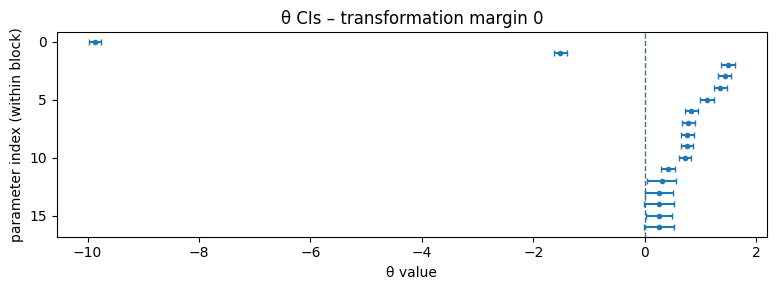

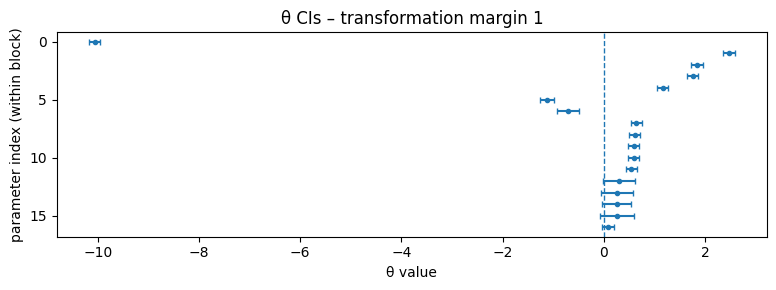

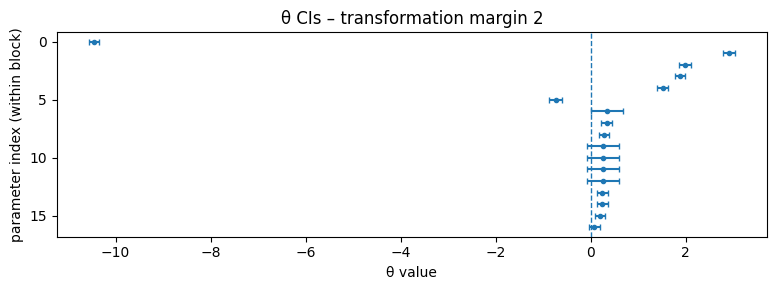

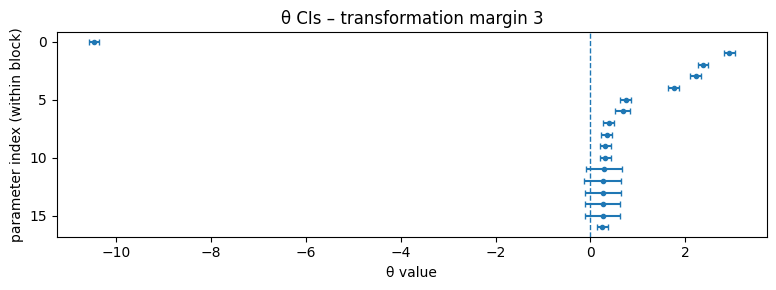

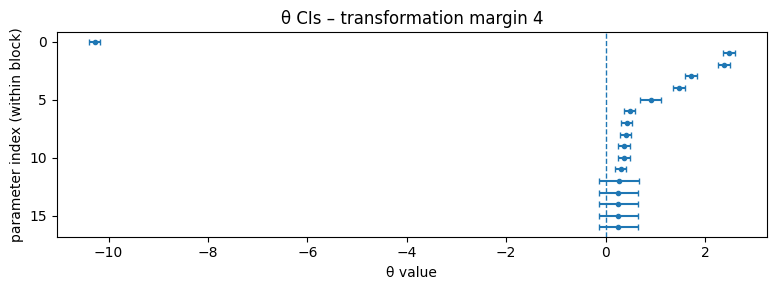

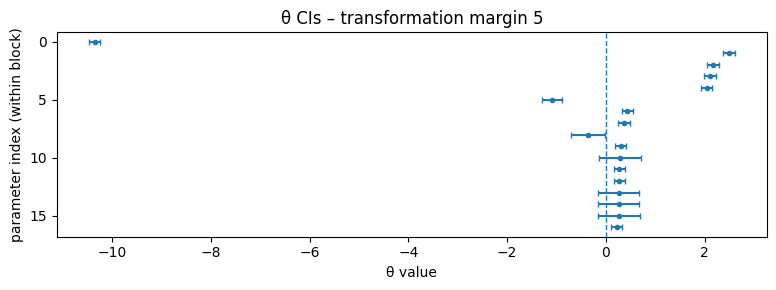

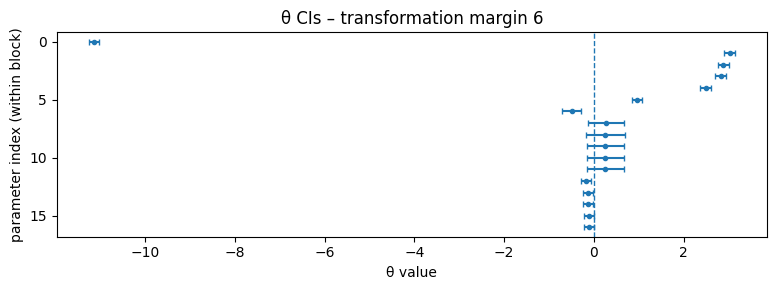

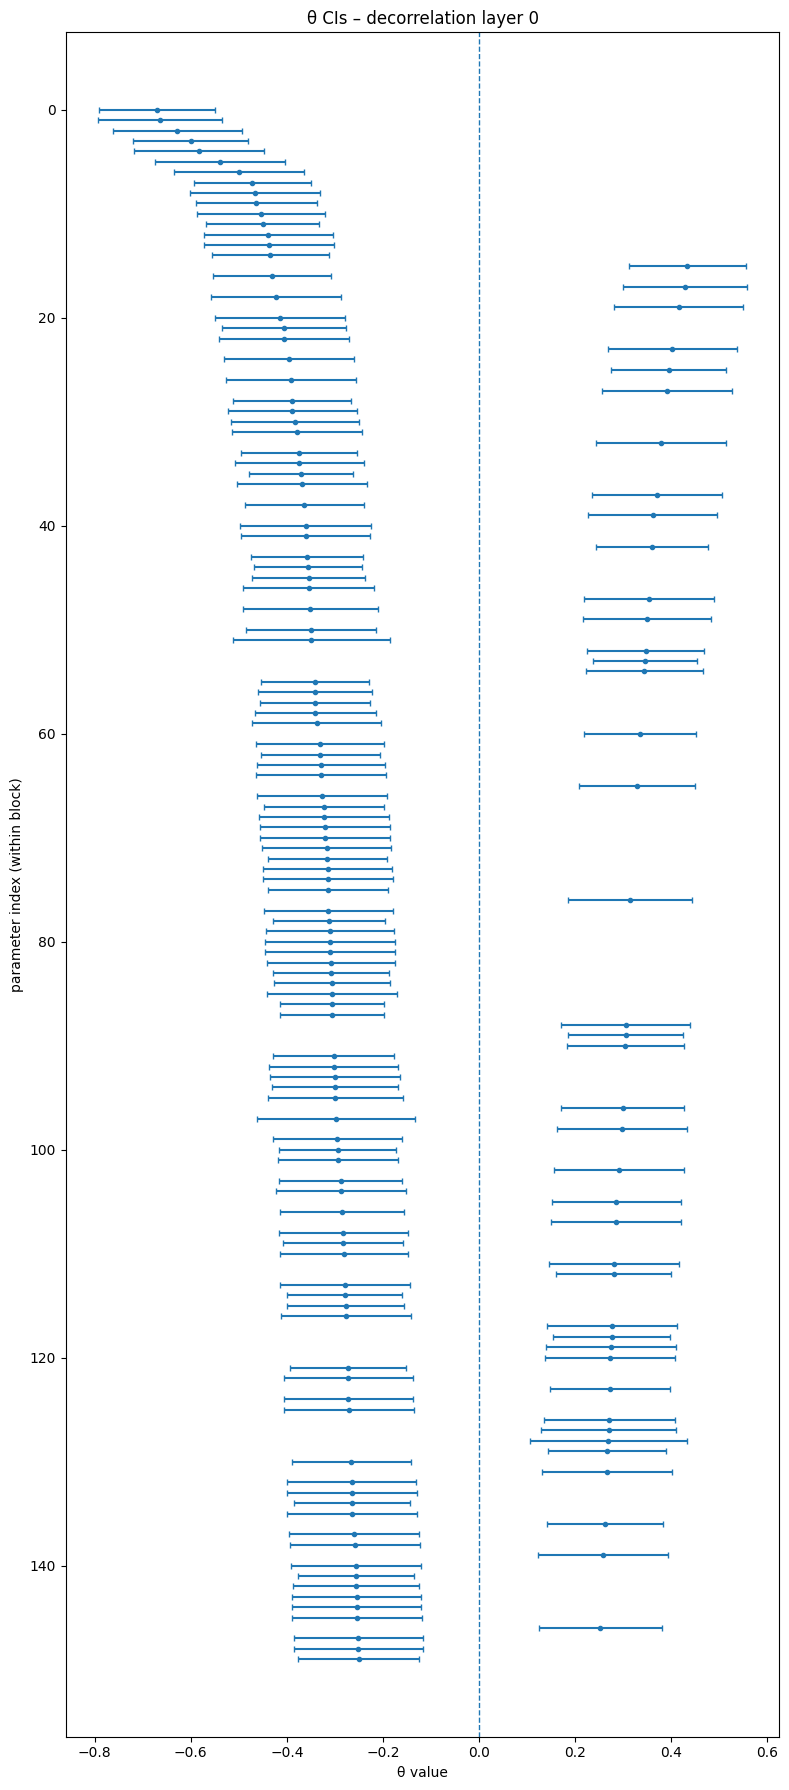

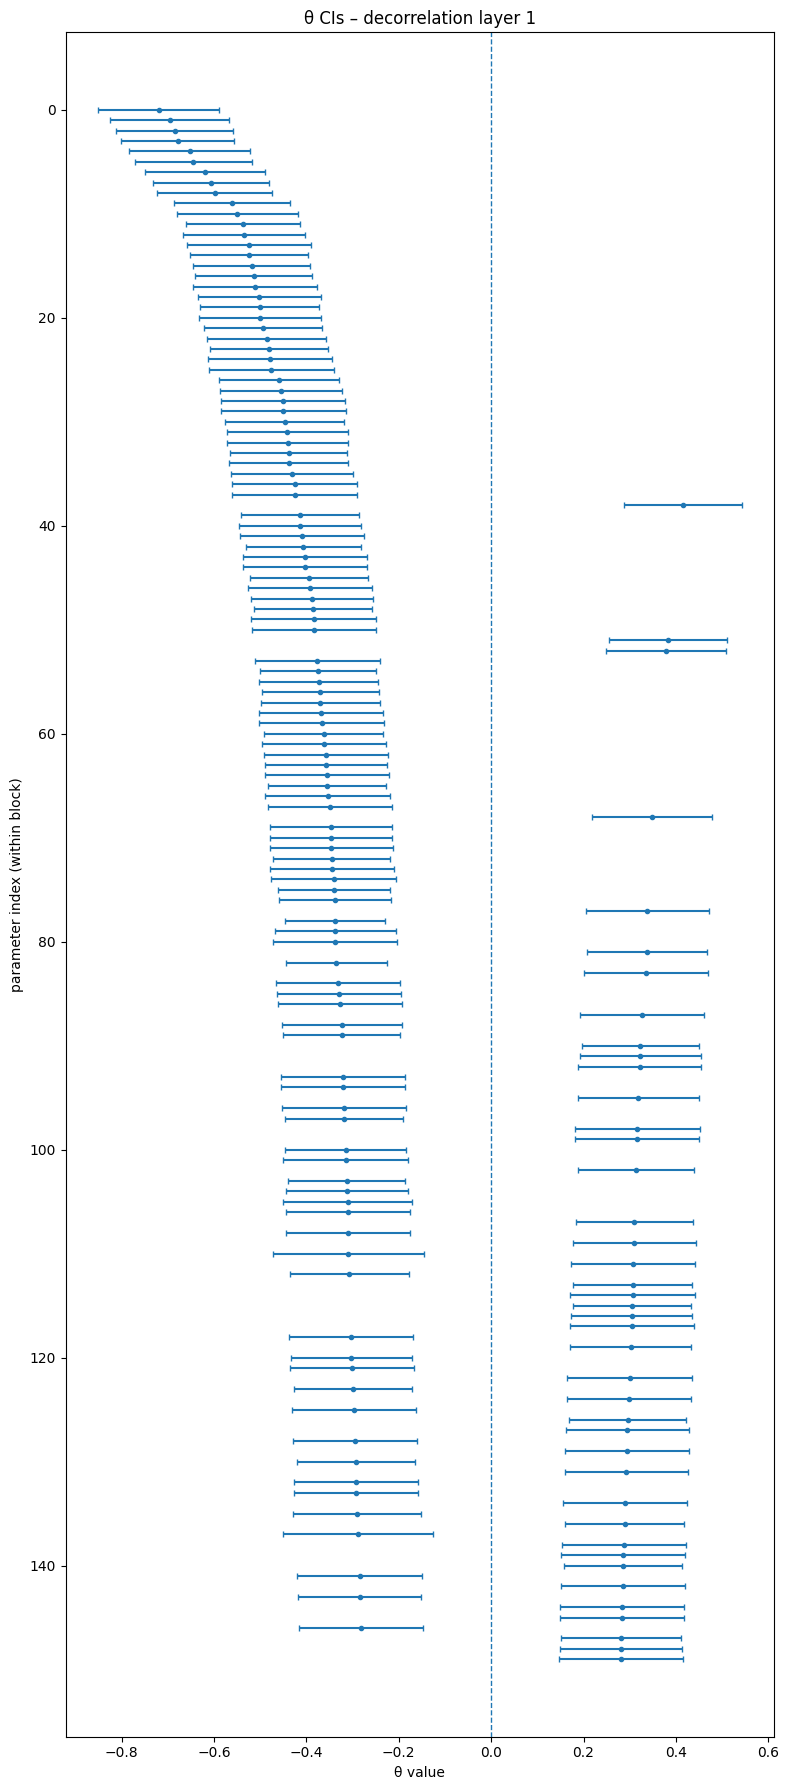

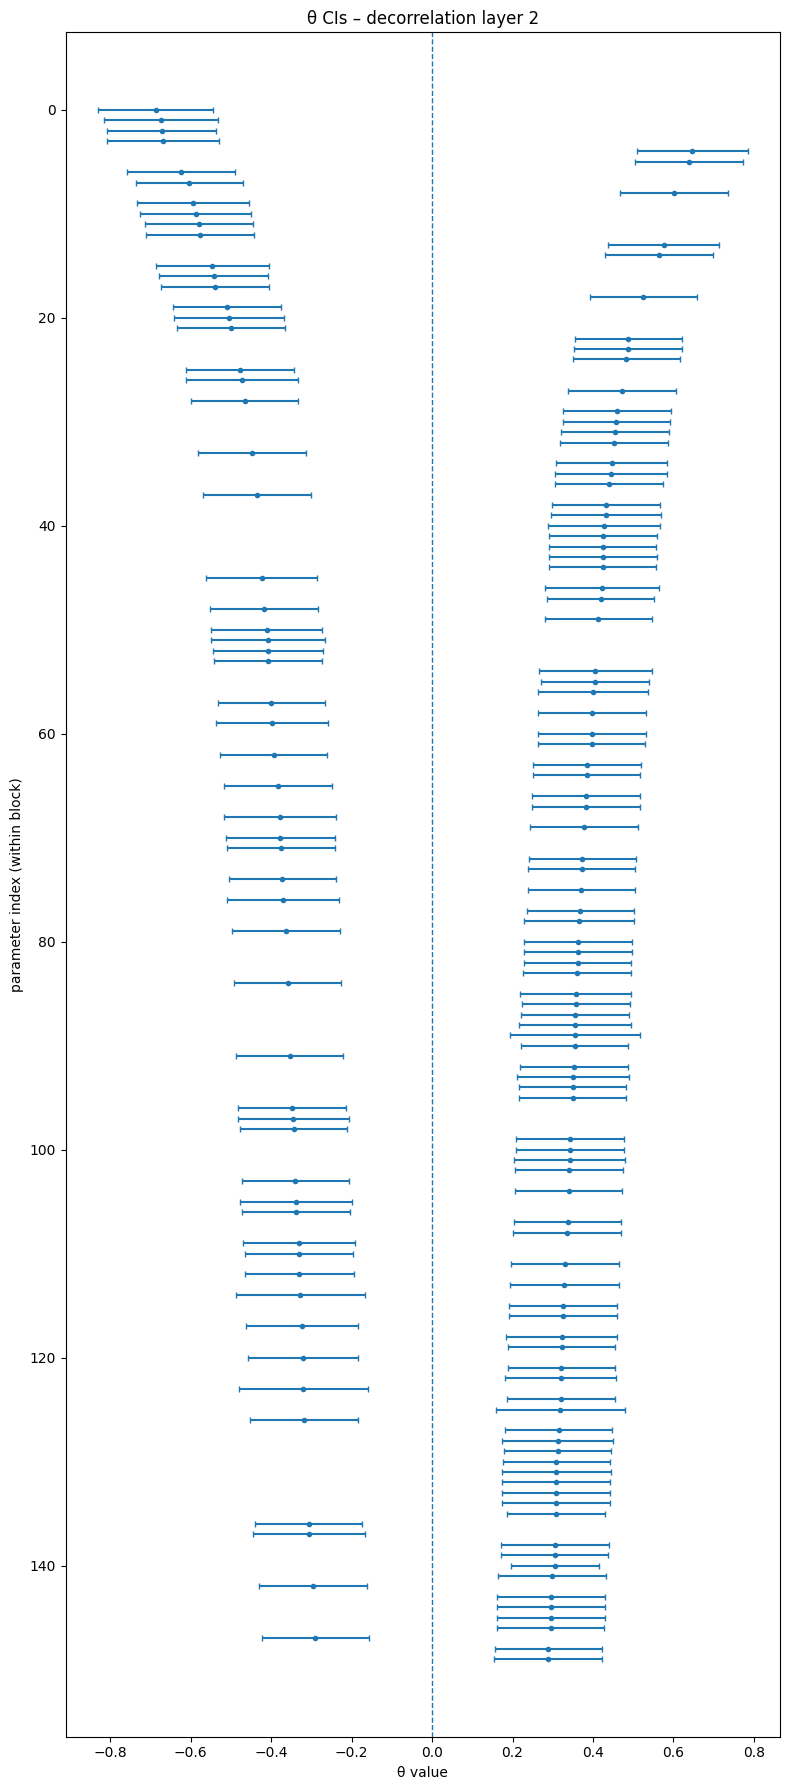

In [64]:
ci_blocks = theta_ci_by_schema(VI, level=0.95, sort_within_group=True)

# Transformation per margin
for j in range(7):
    key = f"transformation.params.{j}"
    plot_theta_ci_block(ci_blocks[key], title=f"θ CIs – transformation margin {j}", max_params=150)

# Decorrelation layers
for ℓ in range(3):
    key = f"decorrelation_layers.{ℓ}.params"
    plot_theta_ci_block(ci_blocks[key], title=f"θ CIs – decorrelation layer {ℓ}", max_params=150)


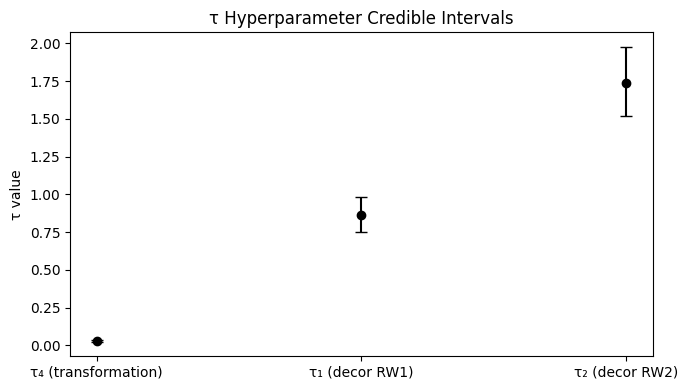

In [65]:
ci_4 = tau_ci_from_node(tau_nodes.node4)
ci_2 = tau_ci_from_node(tau_nodes.node2)
ci_1 = tau_ci_from_node(tau_nodes.node1)

tau_info = [
    ("τ₄ (transformation)", ci_4["mean"], ci_4["lower"], ci_4["upper"]),
]
if True: ### decor_present output from train method
    tau_info += [
        ("τ₁ (decor RW1)", ci_1["mean"], ci_1["lower"], ci_1["upper"]),
        ("τ₂ (decor RW2)", ci_2["mean"], ci_2["lower"], ci_2["upper"]),
    ]
plot_tau_nodes(tau_info)

we plot synthetic samples and overlay the conditional dependence structure for all pairs with strong conditional dependence according to there IAE metric.

In [66]:
synthetic_samples = model.sample(2000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1299: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


[FIX] var 0: valid interval = [-9.999999, 9.999999]
[FIX] var 1: valid interval = [-9.999999, 9.999999]
[FIX] var 2: valid interval = [-9.999999, 9.999999]
[FIX] var 3: valid interval = [-9.999999, 9.999999]
[FIX] var 4: valid interval = [-9.999999, 9.999999]
[FIX] var 5: valid interval = [-9.999999, 9.999999]
[FIX] var 6: valid interval = [-9.999999, 9.999999]
[FIX] var 7: valid interval = [-9.999999, 9.999999]


/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


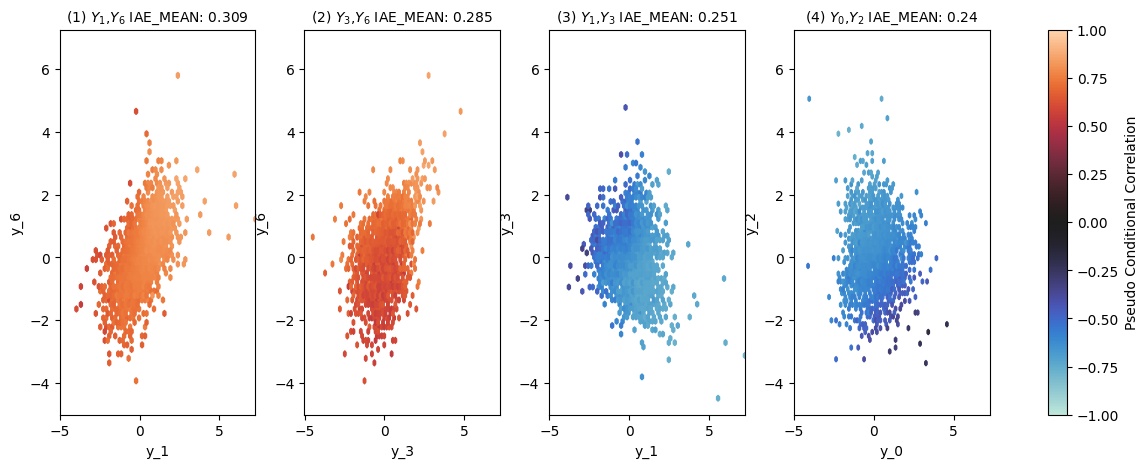

In [67]:
model.plot_conditional_dependence_structure(data=synthetic_samples,
                          dependence_metric_threshholding="iae_mean",
                          minimum_dependence_threshold=0.2, 
                          )

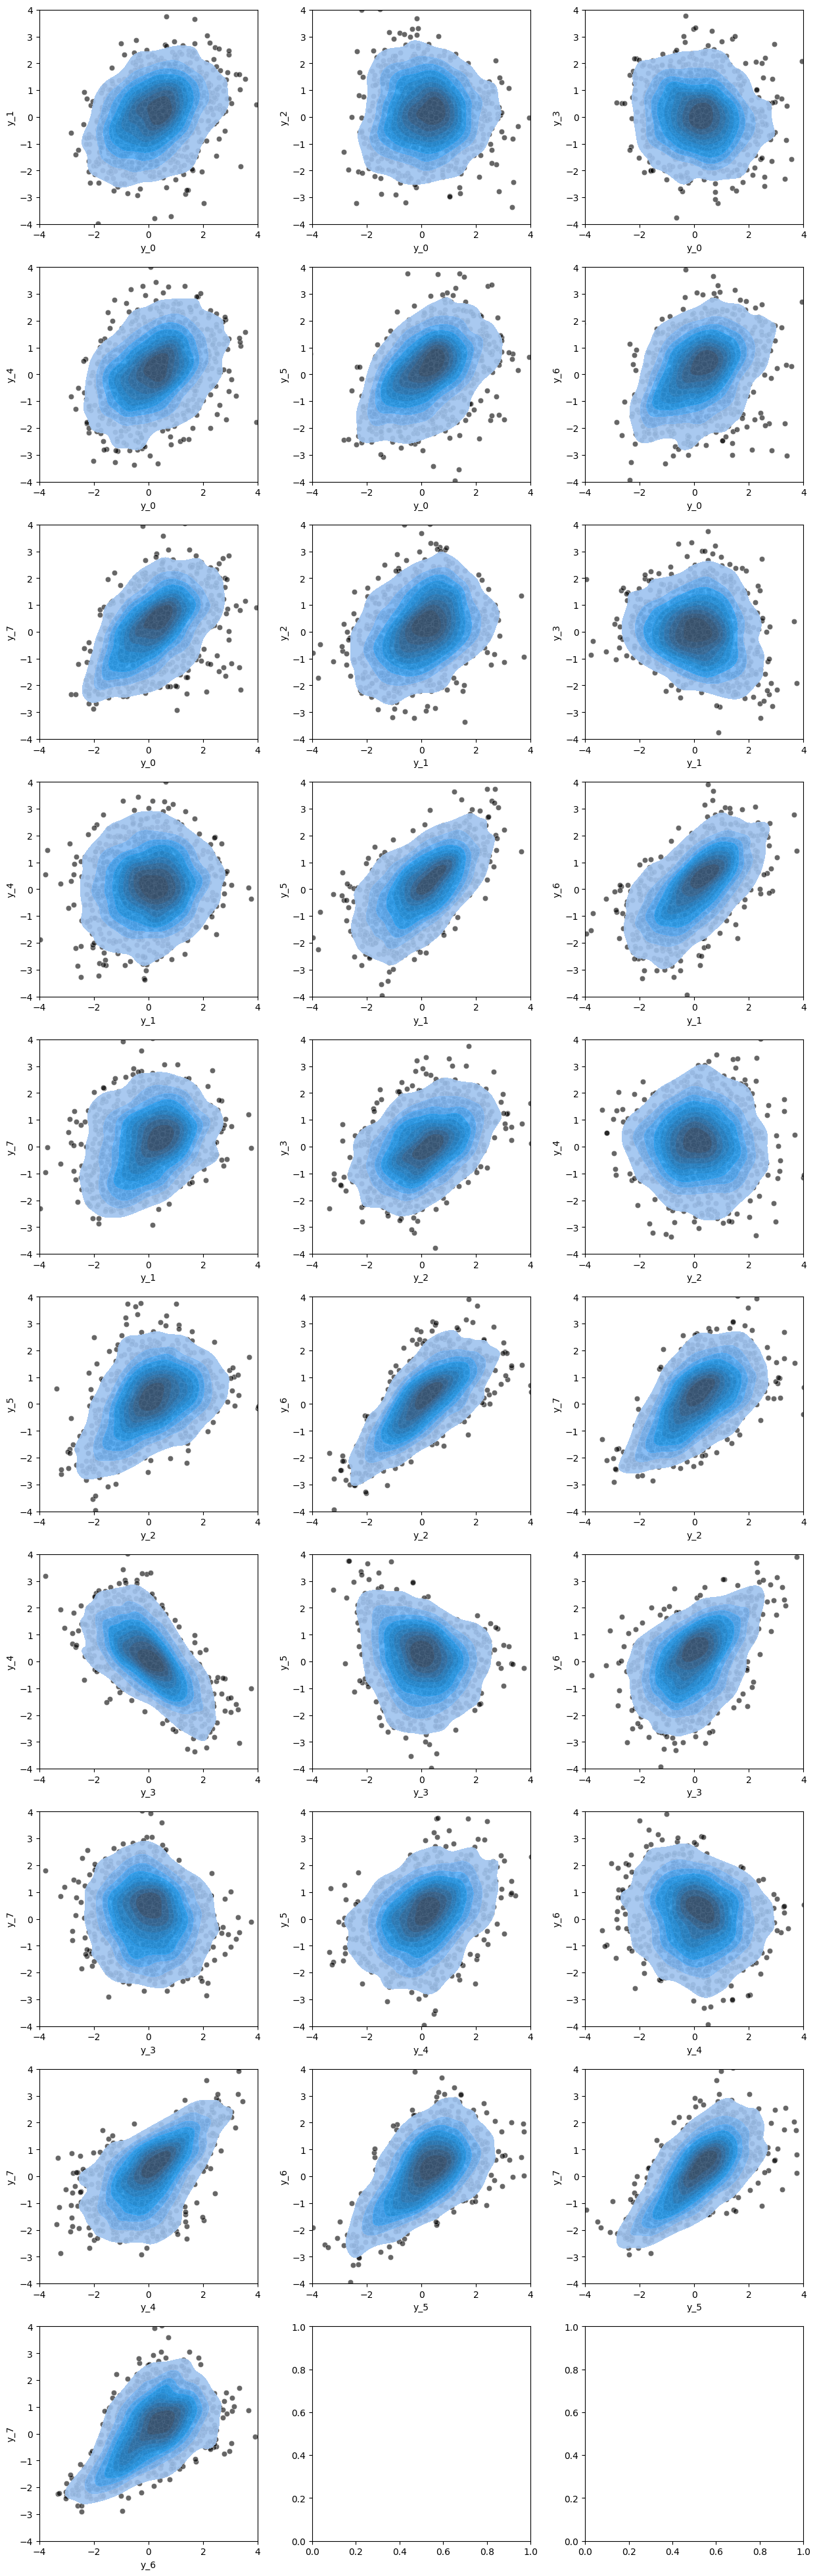

In [68]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The splines of the model, 10 transformation layer splines and 3 x 45 decorrelation layer splines can also be plotted.

In [69]:
#model.plot_splines(layer_type="transformation")

In [70]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

In [71]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

In [72]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)

### 6. Identifying the Conditional Independence Graph

We compare the true known conditional independence Graph to the one learned by the GTM. To do so we first merge the true structure table with our learned one.

In [73]:
merged_ci_tables = pd.merge(
    conditional_independence_table,
    df_true_structure_sub,
    on=["var_row", "var_col"]
)


take a look at the table and sort by some idicator such as iae.

In [74]:
#merged_ci_tables.sort_values("iae",ascending=False) 

with the spearman and pearson correlations one can see how similar the metrics are and how strongly correlated they are to the dependence.

In [75]:
merged_ci_tables.corr("spearman") #"pearson"

,index,var_row,var_col,abs_mean,mean,std,min,q_1,q_5,q_10,...,cond_correlation_abs_lo,cond_correlation_abs_hi,cond_correlation_square_mean,kld_mean,kld_lo,kld_hi,iae_mean,iae_lo,iae_hi,dependence
index,1.000000,0.982607,0.619978,0.367816,-0.385878,0.320744,-0.416530,-0.391899,-0.380952,-0.383689,...,0.328955,0.323481,0.319102,0.398467,0.398467,0.398467,0.382594,0.384784,0.380952,0.589541
var_row,0.982607,1.000000,0.470238,0.389088,-0.401900,0.337841,-0.431423,-0.405799,-0.396886,-0.399393,...,0.340626,0.340069,0.331992,0.399115,0.399115,0.399115,0.401900,0.404406,0.399393,0.590954
var_col,0.619978,0.470238,1.000000,0.084391,-0.100545,0.054868,-0.106672,-0.099709,-0.093303,-0.096924,...,0.118648,0.098873,0.111407,0.191341,0.191341,0.191341,0.098873,0.098873,0.101937,0.329310
abs_mean,0.367816,0.389088,0.084391,1.000000,-0.318008,0.827039,-0.361248,-0.335523,-0.318555,-0.319650,...,0.967159,0.979201,0.978654,0.953476,0.953476,0.953476,0.974275,0.974822,0.972633,0.651598
mean,-0.385878,-0.401900,-0.100545,-0.318008,1.000000,-0.344280,0.973180,0.987411,0.995074,0.997263,...,-0.249042,-0.262726,-0.265463,-0.210728,-0.210728,-0.210728,-0.261631,-0.262726,-0.257800,-0.394505
std,0.320744,0.337841,0.054868,0.827039,-0.344280,1.000000,-0.448276,-0.403394,-0.364532,-0.361248,...,0.793651,0.784346,0.783799,0.802408,0.802408,0.802408,0.819923,0.817187,0.820471,0.704790
min,-0.416530,-0.431423,-0.106672,-0.361248,0.973180,-0.448276,1.000000,0.995074,0.983580,0.981938,...,-0.288451,-0.296661,-0.295567,-0.269294,-0.269294,-0.269294,-0.320197,-0.318008,-0.318008,-0.474292
q_1,-0.391899,-0.405799,-0.099709,-0.335523,0.987411,-0.403394,0.995074,1.000000,0.993432,0.992885,...,-0.265463,-0.272578,-0.273125,-0.240832,-0.240832,-0.240832,-0.289546,-0.288451,-0.286809,-0.438831
q_5,-0.380952,-0.396886,-0.093303,-0.318555,0.995074,-0.364532,0.983580,0.993432,1.000000,0.999453,...,-0.256705,-0.263820,-0.266557,-0.220580,-0.220580,-0.220580,-0.268747,-0.267652,-0.266557,-0.403370
q_10,-0.383689,-0.399393,-0.096924,-0.319650,0.997263,-0.361248,0.981938,0.992885,0.999453,1.000000,...,-0.255610,-0.264368,-0.267105,-0.217296,-0.217296,-0.217296,-0.265463,-0.264915,-0.262726,-0.403370


however the proper metric as identifying full conditional independence is a classification task is the AUC (Area under the ROC-Curve).

In [76]:
auc_iae = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
auc_kld = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
auc_corr = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
auc_pmat = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
print("AUC IAE                    :",auc_iae)
print("AUC KLD                    :",auc_kld)
print("AUC Conditional Correlation:",auc_corr)
print("AUC Precision Matrix       :",auc_pmat)

AUC IAE                    : 0.8820512820512821
AUC KLD                    : 0.8871794871794872
AUC Conditional Correlation: 0.8461538461538463
AUC Precision Matrix       : 0.8820512820512821


We further print the ROC Curves for different metrics.

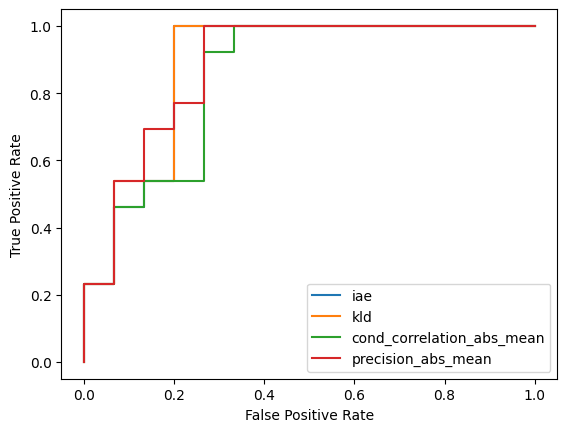

In [77]:
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
plt.plot(fpr, tpr, label="iae")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
plt.plot(fpr, tpr, label="kld")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
plt.plot(fpr, tpr, label="cond_correlation_abs_mean")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
plt.plot(fpr, tpr, label="precision_abs_mean")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()